# Systematic Equity Trading using Machine Learning

## Machine Learning Engineer Nanodegree - Capstone Project

In this project, we explore the US equity fundamentals database, hosted at [usfundamentals.com](http://www.usfundamentals.com), to see if we can use unsupervised and supervised learning techniques to predict equity prices.  We attempt to find similarities using common financial ratios across all companies in the dataset to see if any persistent anomalies can be discovered.  We will be using 5 years of quaterly data, which is originally retrieved from the individual companies public filings with the SEC.  The data is supplemented with additional data linking the individual companies in the database with historical prices retrieved from publicly available sources (Yahoo Finance and Google Finance); this is done by first retrieving trading tickers by querying Edgar and then using the associated tickers as required.

## Getting Started

We start by importing important modules, defining functions needed to retrieve the trading tickers and preparing the final database for exploration.

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
import seaborn as sns
from pandas.io import data, wb
#from pandas_datareader import data, wb
import sys
import datetime
import matplotlib.pyplot as plt
import operator
import itertools
from textwrap import wrap
#from tqdm import tqdm
%matplotlib inline

/Users/faisal/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/faisal/anaconda/envs/python2/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)
/Users/faisal/anaconda/envs/python2/lib/python2.7/site-packages/pandas/io/wb.py:21: FutureWarning: 
The pandas.io.wb module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader 

We define some functions to query the website using their API, the database can also be downloaded by first registering with the website.

In [3]:
#Everyone must use their own access token as per the use agreement (this is free):
fundamentalsAccessToken = '7uD00n7eLJH8O2pk7jMVUg'
#When this variable is True, the code will attempt to refresh all queries.  Otherwise it will ignore the calls and
#load from most recent saved files.
globalUpdate = False

In [4]:
def getIndicatorByCategory(inputCategory=None, inputCompanies=None, inputFrequency='q', perType='yq'):
    #This function returns the data for a specific category.
    #Returns all values when input category and companies are None.  Othewise, can submit a list of values.
    if inputCategory is None:
        if inputCompanies is None:
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?frequency=' + inputFrequency + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
        else:
            if np.shape(inputCompanies) == ():
                inputCompanies = [inputCompanies]
            inputCompanies = np.array(map(str, map(int, inputCompanies)))
            inputCompanies = ",".join(inputCompanies)
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?companies=' + inputCompanies + '&frequency=' + inputFrequency + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
    else:
        if np.shape(inputCategory) == ():
            inputCategory = [inputCategory]
        inputCategory = ",".join(inputCategory)
        if inputCompanies is None:
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
        else:
            if np.shape(inputCompanies) == ():
                inputCompanies = [inputCompanies]
            inputCompanies = np.array(map(str, map(int, inputCompanies)))
            inputCompanies = ",".join(inputCompanies)
            return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl?companies=' + inputCompanies + '&frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)

def getCompanyMeta(inputCompanies=None):
    #This function retrieves a full company list and their reporting name history
    if inputCompanies is None:
        return pd.read_csv('https://api.usfundamentals.com/v1/companies/xbrl?format=csv&token=' + fundamentalsAccessToken)
    else:
        if np.shape(inputCompanies) == ():
            inputCompanies = [inputCompanies]
        inputCompanies = np.array(map(str, map(int, inputCompanies)))
        inputCompanies = ",".join(inputCompanies)
        return pd.read_csv('https://api.usfundamentals.com/v1/companies/xbrl?companies=' + inputCompanies + '&format=csv&token=' + fundamentalsAccessToken)
        
def getIndicatorMeta(inputCategory=None, inputFrequency='q', perType='yq'):
    #Use this function to retrieve information on all indicators
    if inputCategory is None:
        return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl/meta?frequency=' + inputFrequency + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)
    else:
        if np.shape(inputCategory) == ():
            inputCategory = [inputCategory]
        inputCategory = ",".join(inputCategory)
        return pd.read_csv('https://api.usfundamentals.com/v1/indicators/xbrl/meta?frequency=' + inputFrequency + '&indicators=' + inputCategory + '&period_type=' + perType + '&token=' + fundamentalsAccessToken)

def formatIndicatorString(inputString, wrapword=False, wrap_length=35):
    #Returns the indicator label separated by word
    tempword = reduce(lambda x,y: x+y, map(lambda x,y: y+x, inputString, map(lambda x:' ' if x==x.upper() else '', inputString)))[1:]
    if wrapword:
        return "\n".join(wrap(tempword, wrap_length))
    else:
        return tempword

## Data Exploration

We now go start exploring the data set, starting with the number of companies and then the number of features and corresponding time span.

In [5]:
if globalUpdate:
    allCompanies = getCompanyMeta()
    allCompanies.to_csv('allCompanies.csv')
else:
    allCompanies = pd.read_csv('allCompanies.csv', index_col=0)

display(allCompanies.head())
companies = pd.DataFrame(allCompanies.iloc[:, 1:].values, allCompanies.iloc[:, 0].values, columns=allCompanies.iloc[:, 1:].columns)
#See the transformed results for a quick comparison as a check
companies.sort_index(inplace=True)
display(companies.loc[allCompanies.iloc[:, 0].head().values])
display(companies.describe())

,company_id,name_latest,names_previous
0,1000045,Nicholas Financial Inc,NaN
1,1000180,Sandisk Corp,NaN
2,1000209,Medallion Financial Corp,NaN
3,1000228,Henry Schein Inc,NaN
4,1000229,Core Laboratories N V,NaN


,name_latest,names_previous
1000045,Nicholas Financial Inc,NaN
1000180,Sandisk Corp,NaN
1000209,Medallion Financial Corp,NaN
1000228,Henry Schein Inc,NaN
1000229,Core Laboratories N V,NaN


,name_latest,names_previous
count,12199,2079
unique,12172,2078
top,"Northfield Bancorp, Inc.",Windstream Corp
freq,2,2


In total, we have 12,170 companies in the sample.  We can now start looking in to the dataset to see what type of features are available and whether or not the database is complete.

In [6]:
#Retrieve all possible features that we can use from the database.
if globalUpdate:
    allLabels = getIndicatorMeta(inputFrequency='q', perType='yq')
    allLabels.to_csv('allLabels.csv')
else:
    allLabels = pd.read_csv('allLabels.csv', index_col=0)
display(allLabels.head())
display(allLabels.describe())
display(pd.DataFrame(allLabels.gt(0).sum().ix[1:], columns=['Total Values by Year']))
display(pd.DataFrame(allLabels.sum(axis=1), columns=['Total Values by Feature']).describe())

,Indicator ID,Total,2010,2011,2012,2013,2014,2015,2016
0,LiabilitiesAndStockholdersEquity,402255,75,16720,25727,26654,26597,25802,12510
1,Assets,401706,78,16695,25753,26613,26564,25746,12453
2,CashAndCashEquivalentsAtCarryingValue,364047,79,15282,23267,23898,24027,23463,11333
3,StockholdersEquity,362172,67,14513,23166,24131,24083,23444,11320
4,NetIncomeLoss,353946,72,14418,22418,23325,23494,23012,11243


,Total,2010,2011,2012,2013,2014,2015,2016
count,8517.000000,8517.000000,8517.000000,8517.000000,8517.000000,8517.000000,8517.000000,8517.000000
mean,4190.947869,0.700364,136.454620,258.040859,286.452742,290.049665,286.238347,139.046026
std,20598.198535,4.788153,821.752626,1299.368339,1376.887300,1386.135681,1358.433108,660.254649
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.000000,0.000000,0.000000,2.000000,3.000000,3.000000,2.000000,1.000000
50%,336.000000,0.000000,6.000000,16.000000,20.000000,21.000000,21.000000,10.000000
75%,1563.000000,0.000000,38.000000,94.000000,104.000000,106.000000,107.000000,52.000000
max,402255.000000,79.000000,16720.000000,25753.000000,26654.000000,26597.000000,25802.000000,12510.000000


,Total Values by Year
Total,8517
2010,940
2011,5992
2012,7043
2013,7342
2014,7245
2015,6951
2016,6567


,Total Values by Feature
count,8517.000000
mean,5587.930492
std,27464.264713
min,4.000000
25%,88.000000
50%,448.000000
75%,2084.000000
max,536340.000000


Based on the results, we can see that there are a total of 8515 separate features, however, not all of them are reported by all companies.  Furthermore, the data for 2010 is incomplete as there are only 940 datapoints greater than 0; this year should be dropped.  We need to now decide how many features to keep.  To do this, we can plot the total submissions by feature, sorted from highest to lowest (for the Total column):

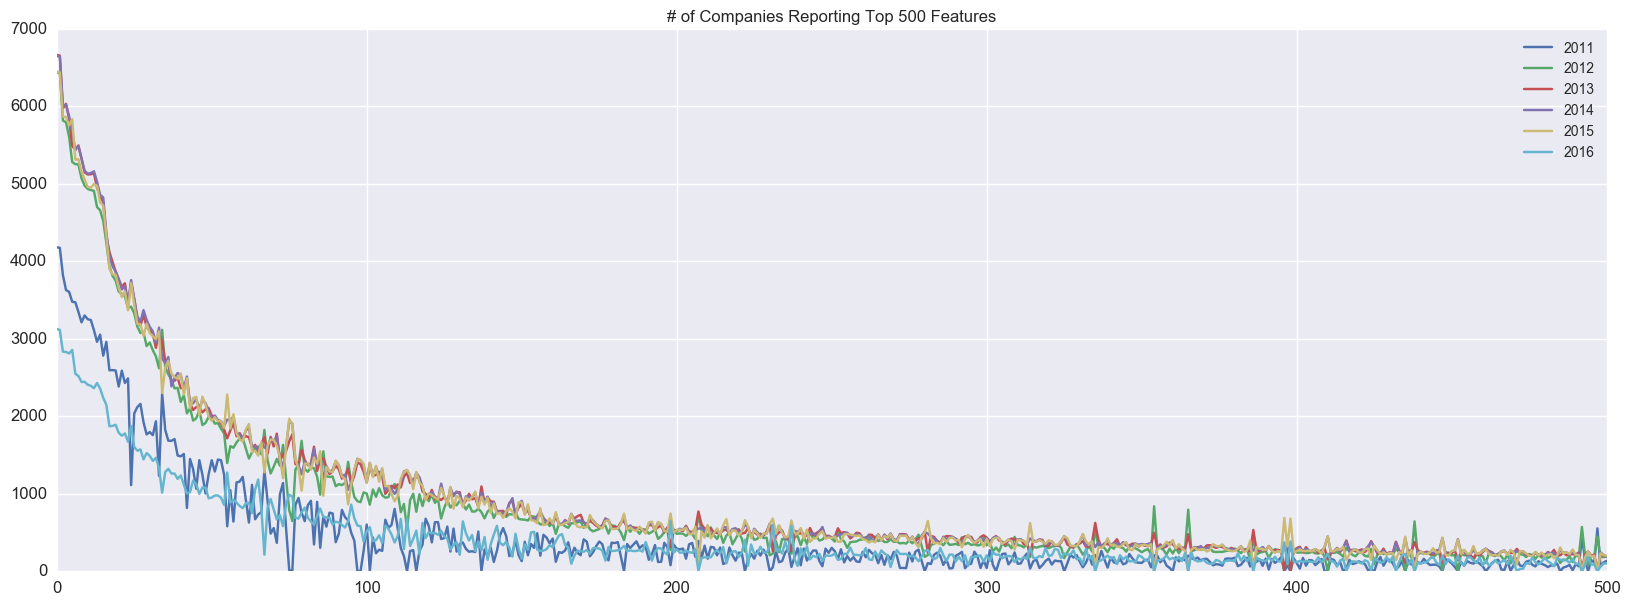

In [7]:
#First drop the unnecessary year
allLabels = allLabels.drop(['2010'], axis=1, inplace=False)

#Plot total by feature, we divide by 4 because the totals are summed up quarterly and this allows us to get an
#estimate of number of companies since each company reports 4 times per year.
for c in range(2, 8):
    allLabels.ix[:500, c].divide(4).plot(legend=True, figsize=(20, 7), title='# of Companies Reporting Top 500 Features', fontsize=12)

Looking at the graph above, we can see that the number of companies reporting a particular feature is not constant.  This is expected as most companies will report the major line items of the income statement but may not to do so with some other subset.  To keep a decent sample, we can keep the cutoff at the top 50 features, which gives us with approximately 1000 companies (most likely the largest 1000 companies).

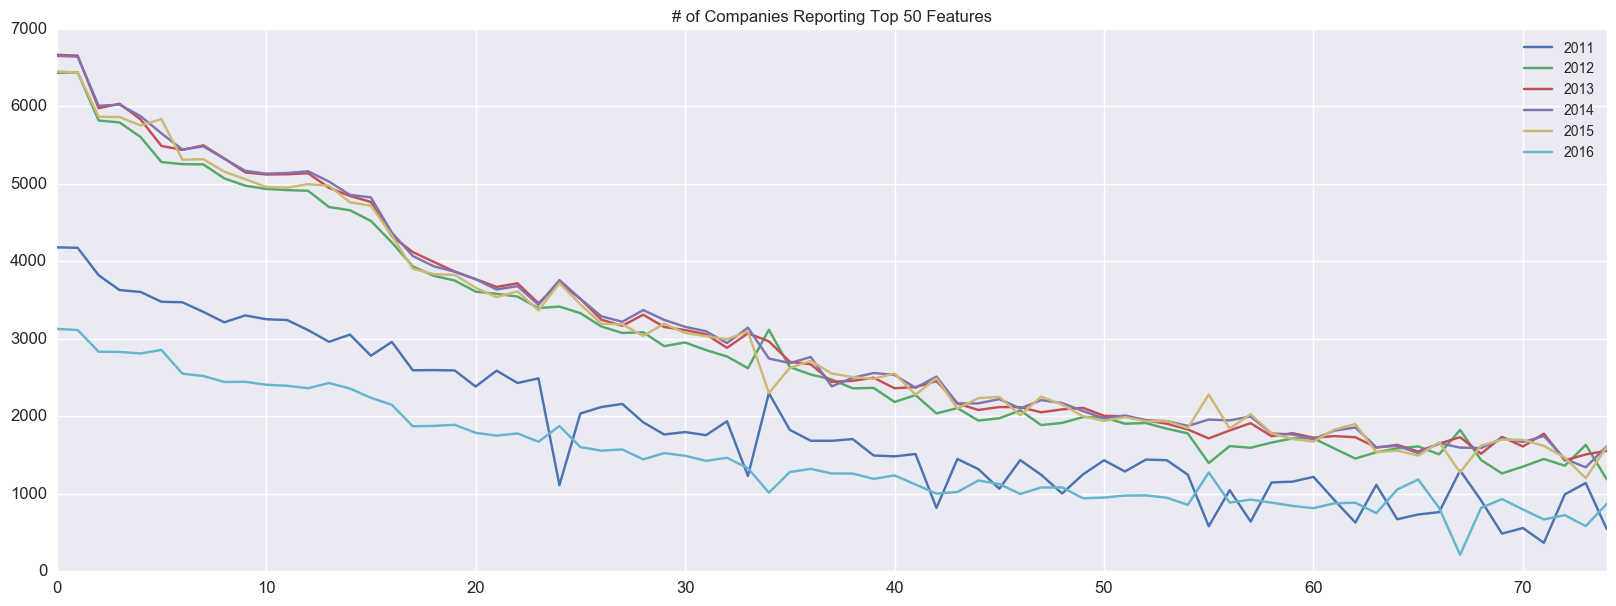

In [8]:
#We can now drop everything except the top 75 features and recreate the plot:
allLabels.drop(allLabels.ix[75:].index, axis=0, inplace=True)
for c in range(2, 8):
    allLabels.ix[:, c].divide(4).plot(legend=True, figsize=(20, 7), title='# of Companies Reporting Top 50 Features', fontsize=12)

Now we are ready to explore the data a little further.  So far we have dropped 2010 from the analysis and restricted the data to the Top 50 most reported features.  If each company reports each line item only once per quarter, then our sample should include atleast 1000 companies.  The next step is to create a final feature list and import the relevant feature data for all companies.  Note that we have not been through the feature list or apply any domain knowledge so far.

In [9]:
reducedLabels = allLabels.ix[:, 0]
#We come up with a date vector of possible time periods.  If the no data is available for a specific period it will 
#be dropped later on
finalDateLabels = np.array([x + 'Q' for x in allLabels.columns.values if x.isdigit()])
finalDateLabels = np.array(map(lambda x: np.core.defchararray.add(x, np.array(map(str, range(1,5)))), finalDateLabels)).flatten()
finalDates = pd.date_range('1/1/' + finalDateLabels[0][:4], periods=len(finalDateLabels), freq='Q')
display(finalDateLabels)
display(finalDates)
display(pd.DataFrame(reducedLabels))

array(['2011Q1', '2011Q2', '2011Q3', '2011Q4', '2012Q1', '2012Q2',
       '2012Q3', '2012Q4', '2013Q1', '2013Q2', '2013Q3', '2013Q4',
       '2014Q1', '2014Q2', '2014Q3', '2014Q4', '2015Q1', '2015Q2',
       '2015Q3', '2015Q4', '2016Q1', '2016Q2', '2016Q3', '2016Q4'], 
      dtype='|S6')

DatetimeIndex(['2011-03-31', '2011-06-30', '2011-09-30', '2011-12-31',
               '2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

,Indicator ID
0,LiabilitiesAndStockholdersEquity
1,Assets
2,CashAndCashEquivalentsAtCarryingValue
3,StockholdersEquity
4,NetIncomeLoss
5,RetainedEarningsAccumulatedDeficit
6,CommonStockValue
7,CommonStockSharesAuthorized
8,CommonStockSharesIssued
9,PropertyPlantAndEquipmentNet


We will now retrieve the data for the final feature list for all available companies and explore further.

In [10]:
#Import top 75 feature data for all companies.  We download separately since server kept crashing.
if globalUpdate:
    companyData = pd.DataFrame()
    for c in range(len(reducedLabels)):
        eachFeature = reducedLabels[c]
        print('Importing ' + str(c) + ' of 75.')
        tempdata = getIndicatorByCategory(inputCategory=eachFeature)
        tempdata.index = tempdata.loc[:, 'company_id']
        companyData = pd.concat([companyData, pd.DataFrame(pd.melt(tempdata.ix[companies.index, finalDateLabels], value_name=eachFeature).iloc[:, 1:])], axis=1)
        #companyData[eachFeature] = tempdata.iloc[:, 2:]
        #companyData[eachFeature].index = tempdata.iloc[:, 0].values
        clear_output(wait=True)
    dataIndex = finalDates
    dataIndex = pd.MultiIndex.from_product([dataIndex.values, companies.index.values], names=['Date', 'Company_ID'])
    companyData.index = dataIndex
    companyData.dropna(how='all', inplace=True)
    #companyData.drop(tempdata[tempdata].index, inplace=True)
    companyData.to_csv('companyData.csv')
else:
    companyData = pd.read_csv('companyData.csv', index_col=[0,1], parse_dates=[0])

#Drop those rows with no values.
companyData.dropna(how='all', inplace=True)
#companyData = companyData.divide(companyData.loc[:, 'LiabilitiesAndStockholdersEquity'], axis=0)
#companyData.drop(['LiabilitiesAndStockholdersEquity'], axis=1, inplace=True)
#companyData.replace([np.inf, -np.inf], np.nan, inplace=True)

#Now we create a function to easily query our MultiIndex database by date and company on the X-axis and features as columns
def getCompanyData(startdate=None, enddate=None, companyid=None, features=None):
    if startdate is None:
        startdate = companyData.index[0][0]
    if enddate is None:
        enddate = companyData.index[-1][0]
    if companyid is None:
        companyid = companies.index
    if features is None:
        features = reducedLabels
    return companyData.ix[pd.MultiIndex.from_product([pd.date_range(startdate, enddate, freq='Q'), companyid]).values, features]

#Run a query
display(getCompanyData(startdate=pd.Timestamp('2015-01-31'), enddate=pd.Timestamp('2015-12-31'), companyid=[1750, 6955], features=['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted']))

WeightedAverageNumberOfSharesOutstandingBasic  \
Date       Company_ID                                                  
2015-03-31 1750                                           38700000.0   
           6955                                           61759000.0   
2015-06-30 1750                                          -77100000.0   
           6955                                           59617000.0   
2015-09-30 1750                                           34700000.0   
           6955                                         -124471000.0   
2015-12-31 1750                                           34400000.0   
           6955                                           59187000.0   

                       EarningsPerShareDiluted  
Date       Company_ID                           
2015-03-31 1750                          -0.89  
           6955                          -1.05  
2015-06-30 1750                           0.39  
           6955                           0.63  
2015-09-30 1750                           0.65  
           6955                           0.36  
2015-12-31 1750                           0.23  
           6955                           0.26

The above query reveals negative values for the number of shares outstanding.  This is obviously an error and further exploration reveals these type of errors for other companies also.  This is most likely due to a different format that companies use for there annual reporting compared to the quarterly filing.  As a result, we will instead take the median values for each feature over the sample period and get an idea of the cross sectional values of each company:

In [11]:
display(getCompanyData(startdate=pd.Timestamp('2015-01-31'), enddate=pd.Timestamp('2015-12-31'), companyid=[1750, 6955], features=['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted']).median(level=1))

,WeightedAverageNumberOfSharesOutstandingBasic,EarningsPerShareDiluted
Company_ID,,
1750,34550000.0,0.31
6955,59402000.0,0.31


However, we cannot correctly impute the median values unless there are enough observations for each company as well.  Therefore, we will keep only those observations for which a company has reported atleast one years worth of data (i.e. 4 quarters).

In [335]:
companyDataRobustValues = companyData.notnull().sum(level=1).ge(3)

Now we will transform and scale the data:

In [336]:
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler

tempdata = companyData.median(level=1).where(companyDataRobustValues)#.subtract(logCompanyDataTransformation, axis=1)
#print("Total companies excluded as incomplete: " + str(np.shape(getLogData().median(level=1))[0]-np.shape(tempdata)[0]))
#We calculate the percentiles at the company level
#tempdata.where(tempdata.ne(0), np.nan, inplace=True)
tempdata.dropna(how='all', inplace=True)

Q1 = np.nanpercentile(tempdata, 25, axis=0)
Q3 = np.nanpercentile(tempdata, 75, axis=0)
step = 1.5 * (Q3 - Q1)
#Identify potential outliers
potOut = (tempdata.gt(step+Q3) | tempdata.lt(Q1-step))

#Display the percentage of values for each category that qualify as outliers

#display(pd.DataFrame(potOut.sum(axis=0).divide(tempdata.notnull().sum(axis=0)).sort_values(ascending=False).multiply(100), columns=['Outliers (%)']))
#If a company has more than 25% of its reporeted values as outliers, then we will drop those companies.
#tempdata[potOut] = np.nan
#tempdata.dropna(how='all', inplace=True)
tempdata.drop(potOut.index[potOut.sum(axis=1).divide(tempdata.notnull().sum(axis=1)).ge(0.25)], inplace=True)

#companyData = companyData.loc[(slice(None), tempdata.drop(potOut.index[potOut.sum(axis=1).divide(tempdata.notnull().sum(axis=1)).ge(0.33)]).index), :]
#print("Total companies dropped as outliers: " + str(np.shape(tempdata)[0]-np.shape(companyData.median(level=1))[0]))
#print("Total companies remaining is " + str(np.shape(companyData.median(level=1))[0]) + ".")
#tempdata.subtract(logCompanyDataTransformation, axis=1)
#tempdata = tempdata.dropna(how='all')
logCompanyDataShift = tempdata.min(axis=0).subtract(1)
tempdata = tempdata.subtract(logCompanyDataShift, axis=1)

#display(companyData.median(level=1).loc[2034, 'EarningsPerShareDiluted']+29358.950000000001)
#display(tempdata.loc[2034, 'EarningsPerShareDiluted'])

logCompanyData = []
logCompanyDataLambda = []
logCompanyDataTransform = []
for eachFeature in tempdata.columns:
    logCompanyData.append(boxcox(tempdata.loc[:, eachFeature].dropna(how='any').reshape(-1, 1)))
    try:
        logCompanyDataLambda.append(logCompanyData[-1][1][0])
    except:
        logCompanyDataLambda.append(logCompanyData[-1][1])
    logCompanyDataTransform.append(StandardScaler().fit(logCompanyData[-1][0]))
    logCompanyData[-1] = pd.DataFrame(logCompanyDataTransform[-1].transform(logCompanyData[-1][0]), tempdata.loc[:, eachFeature].dropna(how='any').index, columns=[eachFeature])

logCompanyData = reduce(lambda x,y:pd.concat([x,y], axis=1), logCompanyData)
logCompanyDataLambda = pd.Series(logCompanyDataLambda, tempdata.columns, name='Lambda')
logCompanyDataTransform = pd.Series(logCompanyDataTransform, tempdata.columns, name='Robust Transform')
display(np.shape(logCompanyData))

display(logCompanyData.head(5))
display(logCompanyDataShift.head(5))
display(logCompanyDataLambda.head(5))
display(logCompanyDataTransform.head(5))


#tt = logCompanyData.median(level=1)
#finalFeatures = tt.columns.values
#fig, axes = plt.subplots(1+len(finalFeatures)/5, 5, figsize=(20,40), sharex=False)
#fig.subplots_adjust(hspace=.3)
#tempdata = tt
#tempLabels = list(range(len(finalFeatures)))
#while(len(tempLabels)>0):
#    sns.distplot(RobustScaler().fit_transform(tempdata.loc[:, finalFeatures[tempLabels[0]]].dropna(how='any').values), ax=axes[tempLabels[0]/5, np.mod(tempLabels[0], 5)], axlabel=False)
#    axes[tempLabels[0]/5, np.mod(tempLabels[0], 5)].set(title=formatIndicatorString(finalFeatures[tempLabels.pop(0)], wrapword=True, wrap_length=35))

(7772, 75)

,LiabilitiesAndStockholdersEquity,Assets,CashAndCashEquivalentsAtCarryingValue,StockholdersEquity,NetIncomeLoss,RetainedEarningsAccumulatedDeficit,CommonStockValue,CommonStockSharesAuthorized,CommonStockSharesIssued,PropertyPlantAndEquipmentNet,...,CashAndCashEquivalentsPeriodIncreaseDecrease,NetIncomeLossAvailableToCommonStockholdersBasic,DeferredTaxAssetsNetCurrent,ResearchAndDevelopmentExpense,AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount,LongTermDebt,ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsOutstandingNumber,MinorityInterest,InvestmentIncomeInterest,AmortizationOfIntangibleAssets
Company_ID,,,,,,,,,,,,,,,,,,,,,
1750,1.648796,1.447806,1.028849,2.693426,1.723396,2.732366,1.994101,-0.128949,0.327552,1.448750,...,-1.196023,1.385549,1.540162,NaN,0.098979,1.243869,NaN,-0.247629,0.939420,NaN
1961,NaN,NaN,-1.022610,-0.513505,-0.142560,-0.091655,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2034,0.689135,0.684916,0.759054,0.364311,0.533430,0.572135,-0.250750,-0.660386,0.027946,0.210846,...,-0.011693,NaN,-0.788699,-0.33553,-0.174305,0.224984,NaN,NaN,NaN,NaN
2098,-0.098435,0.154231,0.028329,-0.354334,-0.031112,0.155910,0.671112,-1.437012,-0.974726,0.018957,...,-0.036099,NaN,-0.927383,NaN,NaN,NaN,-0.159828,NaN,-0.264282,NaN
2178,0.732108,0.715481,0.967828,0.107307,0.402683,0.594461,-0.235282,-1.464488,-1.011735,0.910950,...,-0.043141,NaN,NaN,NaN,NaN,-1.662132,NaN,NaN,0.039616,NaN


LiabilitiesAndStockholdersEquity        -1.884879e+07
Assets                                  -1.000000e+00
CashAndCashEquivalentsAtCarryingValue   -2.300000e+01
StockholdersEquity                      -1.529100e+09
NetIncomeLoss                           -1.757785e+08
dtype: float64

LiabilitiesAndStockholdersEquity        -0.036194
Assets                                   0.120676
CashAndCashEquivalentsAtCarryingValue    0.124056
StockholdersEquity                       0.354892
NetIncomeLoss                            1.464593
Name: Lambda, dtype: float64

LiabilitiesAndStockholdersEquity         StandardScaler(copy=True, with_mean=True, with...
Assets                                   StandardScaler(copy=True, with_mean=True, with...
CashAndCashEquivalentsAtCarryingValue    StandardScaler(copy=True, with_mean=True, with...
StockholdersEquity                       StandardScaler(copy=True, with_mean=True, with...
NetIncomeLoss                            StandardScaler(copy=True, with_mean=True, with...
Name: Robust Transform, dtype: object

In [337]:
#display(companyData.notnull().sum(level=1).gt(3).sum(axis=0).sort_values())
tempdata = companyData.median(level=1)
#display(tempdata.eq(0).sum().divide(tempdata.notnull().sum()).sort_values(ascending=False))
#print(tempdata.loc[:, 'EarningsPerShareBasicAndDiluted'].dropna(how='any').describe())
display(tempdata.subtract(tempdata.median(), axis=1).abs().median().divide(tempdata.abs().median()).sort_values())
#tt = pd.qcut(tempdata.loc[:, 'CashAndCashEquivalentsPeriodIncreaseDecrease'], [0, 0.25, 0.5, 0.75, 1])
#print(pd.value_counts(tt))
#display(tt.describe())
medStd = tempdata.subtract(tempdata.median(), axis=1).abs().median()
meanStd = tempdata.subtract(tempdata.median(), axis=1).abs().mean()
#display(tempdata.mode())
#display(pd.DataFrame(logCompanyDataLambda.abs().sort_values(ascending=False)))
display(pd.DataFrame(medStd.divide(tempdata.abs().median()).sort_values(ascending=False)))
#display(tempdata.skew().abs().sort_values(ascending=False))
#pd.DataFrame(meanStd.divide(medStd).sort_values(ascending=False))
#fig, axes = plt.subplots(2, 5, figsize=(20,10), sharex=False)
#axes[0][0].set_xlim([-2, 2])
#axes[0][1].set_xlim([-2, 2])
#axes[0][2].set_xlim([-2, 2])
#axes[0][3].set_xlim([-2, 2])
#axes[0][4].set_xlim([-2, 2])
#tempdata.loc[:, 'PreferredStockSharesOutstanding'].dropna(how='any').plot(kind='kde', ax=axes[0][0])
#tempdata.loc[:, 'PreferredStockSharesIssued'].dropna(how='any').plot(kind='kde', ax=axes[0][1])
#tempdata.loc[:, 'EarningsPerShareBasicAndDiluted'].dropna(how='any').plot(kind='kde', ax=axes[0][2])
#tempdata.loc[:, 'PreferredStockValue'].dropna(how='any').plot(kind='kde', ax=axes[0][3])
#tempdata.loc[:, 'CashAndCashEquivalentsPeriodIncreaseDecrease'].dropna(how='any').plot(kind='kde', ax=axes[0][4])
#display(axes.set_xlim([-5, 5]))
#tempdata.loc[:, 'IncomeTaxExpenseBenefit'].dropna(how='any').plot(kind='kde')
#display(tempdata.skew().abs().sort_values(ascending=False))



CommonStockSharesAuthorized                                                                                    0.708333
IncomeTaxExpenseBenefit                                                                                        0.729455
WeightedAverageNumberOfDilutedSharesOutstanding                                                                0.743230
WeightedAverageNumberOfSharesOutstandingBasic                                                                  0.761118
CommonStockSharesOutstanding                                                                                   0.781583
CommonStockSharesIssued                                                                                        0.794226
PreferredStockSharesAuthorized                                                                                 0.800000
StockholdersEquity                                                                                             0.824165
EarningsPerShareBasic                   

,0
ComprehensiveIncomeNetOfTax,1.010843
NetIncomeLossAvailableToCommonStockholdersBasic,1.003829
OperatingIncomeLoss,1.000625
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,1.000527
NetIncomeLoss,1.000443
OtherNonoperatingIncomeExpense,1.000000
PreferredStockParOrStatedValuePerShare,1.000000
CommonStockParOrStatedValuePerShare,1.000000
EarningsPerShareBasicAndDiluted,1.000000
SalesRevenueNet,0.999999


In [338]:
#This function will return the log transformed data
def getLogData(companyid=None, features=None):
    if companyid is None:
        companyid = companies.index
    if features is None:
        features = reducedLabels
    return logCompanyData.ix[companyid, features]

#This function will return the inverse transformation of the boxcox transformed data
def inverseLogData(inputData=None):
    if inputData is None:
        return None
    else:
        inputData = pd.DataFrame(inputData)
        tempLambda = logCompanyDataLambda.loc[inputData.columns]
        tempShift = logCompanyDataShift.loc[inputData.columns]
        tempTransform = logCompanyDataTransform.loc[inputData.columns]
        inputData = map(lambda x: pd.DataFrame(tempTransform[x].inverse_transform(inputData.loc[:, x].dropna(how='any').reshape(-1, 1)), inputData.loc[:, x].dropna(how='any').index, columns=[x]), inputData.columns)
        inputData = reduce(lambda x,y:pd.concat([x,y], axis=1), inputData)
        return inputData.multiply(tempLambda, axis=1).add(1).pow(1/tempLambda, axis=1).add(tempShift, axis=1)

#Test the function
tempdata = getLogData(companyid=[2034], features=['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted'])
display(inverseLogData(tempdata))
#display(np.exp(tempdata.multiply(logCompanyDataStd.loc[['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted']]).add(logCompanyDataMean.loc[['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted']])).subtract(logCompanyDataTransformation.loc[['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted']]))

#Cross check by querying directly from the server:
print("Directly from the server:")
if globalUpdate:
    logDataCrossCheck = getIndicatorByCategory(inputCategory=['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted'], inputCompanies=[2034])
    logDataCrossCheck.to_csv('logDataCrossCheck.csv')
else:
    logDataCrossCheck = pd.read_csv('logDataCrossCheck.csv', index_col=0)

tempdata = pd.DataFrame(logDataCrossCheck.loc[:, finalDateLabels])
tempdata = pd.concat([logDataCrossCheck.loc[:, 'indicator_id'], tempdata], axis=1)
tempdata.index = logDataCrossCheck.loc[:,'company_id']
display(tempdata.T.iloc[1:, :].median())
#display(pd.DataFrame(logCompanyData.loc[pd.MultiIndex.from_product([pd.date_range(pd.Timestamp('2014-06-30'),periods=6, freq='Q'), [320193, 789019]]).values, ['Assets', 'GrossProfit']]).T)




,WeightedAverageNumberOfSharesOutstandingBasic,EarningsPerShareDiluted
Company_ID,,
2034,27033500.0,0.215


Directly from the server:


company_id
2034    2.150000e-01
2034    2.703350e+07
dtype: float64

Work with cross-sectional data instead, using the median value for each feature in the sample period.

In [339]:
tempdata = getCompanyData(startdate=pd.Timestamp('2015-01-31'), enddate=pd.Timestamp('2015-12-31'), companyid=[1750, 6955], features=['WeightedAverageNumberOfSharesOutstandingBasic', 'EarningsPerShareDiluted'])
display(tempdata.median(level=1))

,WeightedAverageNumberOfSharesOutstandingBasic,EarningsPerShareDiluted
Company_ID,,
1750,34550000.0,0.31
6955,59402000.0,0.31


Despite getting matching results after our transformation and reindexing, we can see that there are negative values for the average number of shares outstanding feature.  This is clearly an error as the number of shares outstanding cannot be negative.  We can expect these type of errors to be present for other companies and features also.  Consequently, it is prudent to attempt to identify these outliers before continuing on with the analysis.

### Outlier Detection

Now we will inspect which companies can be classified as outliers.  A company will be considered an outlier if more than a quarter of reported features can be classified as outliers using Tukeys method.  Recall that we are working with the median reported value for each company and therefore this should be highly unlikely unless the company is infact very different from the rest.

In [470]:
tempdata = getLogData().dropna(how='all')#.median(level=1)#.dropna(thresh=len(reducedLabels)*1/3)
print("Total companies excluded as incomplete: " + str(np.shape(getLogData())[0]-np.shape(tempdata)[0]))
#We calculate the percentiles at the company level
Q1 = np.nanpercentile(tempdata.abs(), 25, axis=0)
Q3 = np.nanpercentile(tempdata.abs(), 75, axis=0)
step = 1.5 * (Q3 - Q1)
#Identify potential outliers
potOut = (tempdata.abs().gt(step+Q3, axis=1) | tempdata.abs().lt(Q1-step, axis=1))
#Display the percentage of values for each category that qualify as outliers
#pd.DataFrame(potOut.sum(axis=0).divide(tempdata.notnull().sum(axis=0)).sort_values(ascending=False).multiply(100), columns=['Outliers (%)']).plot()
#display(pd.DataFrame(potOut.sum(axis=0).divide(tempdata.notnull().sum(axis=0)).sort_values(ascending=False).multiply(100), columns=['Outliers (%)']))

#If a company has more than 25% of its reporeted values as outliers, then we will drop those companies.
#tempdata[potOut] = np.nan
#finalData = tempdata.drop(potOut.index[potOut.sum(axis=1).divide(tempdata.notnull().sum(axis=1)).ge(0.25)])
#tempdata[potOut] = np.nan
finalData = tempdata

#display(potOut.sum(axis=1).sort_values(ascending=False).mean(level=1).quantile(0.95))



#Now we must decide whether to drop them or set them to a specific value


print("Total companies dropped as outliers: " + str(np.shape(tempdata)[0]-np.shape(finalData)[0]))
print("Total companies remaining is " + str(np.shape(finalData)[0]) + ".")
#finalData = tempdata.dropna(thresh=24).median(level=1)

#tempdata = tempdata.drop(potOut.index[potOut.sum(axis=1).divide(tempdata.notnull().sum(axis=1)).gt(0.5)]) #dropna(how='all').median(level=1)
#display(np.shape(finalData))

Total companies excluded as incomplete: 4427
Total companies dropped as outliers: 0
Total companies remaining is 7772.


Problem is that there are not that many companies reporting all 75 features:

In [471]:
#Number of companies reporting more than or equal to 70 features:
print('# of companies reporting more than or equal to 70 features: ' + str(finalData.notnull().sum(axis=1).ge(70).sum()))

#Number of companies reporting all of the first 25 most frequently reported features:
print('# of companies reporting the 25th most popular feaure: ' + str(finalData.notnull().sum(axis=0).sort_values(ascending=False).iloc[24]))
print('# of companies reporting all 25 of most frequently reported features: ' + str(finalData.notnull().iloc[:, :25].sum(axis=1).eq(25).sum()))

# of companies reporting more than or equal to 70 features: 0
# of companies reporting the 25th most popular feaure: 4350
# of companies reporting all 25 of most frequently reported features: 370


In the previous output, we can see that even though there were 5366 observations for the 25th most reported feature, only 607 companies reported all of the top 25 features while only 3 reported more than or equal to 70.  In fact, no companies reported all 75.  There are a couple of things going on, first not all features are relevant to all companies.  Second, there are some categories that are very similar and companies may be reporting one or the other.  Consequently, there are some categories that are reported frequently and are essentially the same feature; Assets and Liabilities/Equity are essentially equivalent and are also reported by essentially every company.  On the other hand, there are some infrequently reported features that are essentially representing the same thing.  Take preferred stock issued and outstanding:

In [472]:
display(finalData.loc[:, ['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']].corr())
print('Total values for each category: \n\n' + str(finalData.notnull().sum().loc[['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']]) + '\n')
print('# of companies reporting both: ' + str(finalData.notnull().loc[:, ['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']].product(axis=1).sum()))
print('# of companies reporting atleast one: ' + str(finalData.notnull().loc[:, ['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']].sum(axis=1).gt(0).sum()))

,PreferredStockSharesIssued,PreferredStockSharesOutstanding
PreferredStockSharesIssued,1.000000,0.969615
PreferredStockSharesOutstanding,0.969615,1.000000


Total values for each category: 

PreferredStockSharesIssued         3770
PreferredStockSharesOutstanding    3432
dtype: int64

# of companies reporting both: 3125
# of companies reporting atleast one: 4077


Looking at previous example, we can gain almost 1400 observations by filling in any missing value by with the value for the other feature, if reported.  Although not perfect, if we apply this method to all features that are very highly correlated, increase in sample size may be worthwhile.  We define some functions now to help us do this.

In [473]:
#Returns highest correlated features for a given category 
def getCorrelatedFeatures(inputCategory, maxFeatures=10, correlationCutoff=0.8):
    logCompanyDataCorr = finalData.corr()
    logCompanyDataCorr = logCompanyDataCorr.where(logCompanyDataCorr.gt(correlationCutoff)).iloc[np.argwhere(logCompanyDataCorr.index.values==inputCategory)[0][0], :]
    tempranks = logCompanyDataCorr.rank(ascending=False)
    return logCompanyDataCorr.loc[tempranks[tempranks.gt(1) & tempranks.le(maxFeatures+1)].index.values].sort_values(ascending=False)

#Test the function
display(pd.DataFrame(getCorrelatedFeatures('LongTermDebt', maxFeatures=5, correlationCutoff=0.5)))

#To find highly correlated features, we will start by removing the the feature that has the most pairwise correlations
#below the correlation cutoff.
def findCorrelatedFeatures(inputCategory, correlationCutoff=0.5):
    logCompanyDataCorr = finalData.corr()
    tempdata = logCompanyDataCorr.where(logCompanyDataCorr.gt(correlationCutoff))
    tempdata.values[[np.arange(np.shape(tempdata)[0])]*2] = np.nan
    tempdata.dropna(how='all', inplace=True)
    tempdata.dropna(axis=1, how='all', inplace=True)
    #Now we can reintroduce them at the minimum threshold
    tempdata.values[[np.arange(np.shape(tempdata)[0])]*2] = 1
    #groups = []
    temp = tempdata.ix[tempdata.iloc[np.argwhere(tempdata.index==inputCategory)[0][0], :].notnull(), tempdata.iloc[np.argwhere(tempdata.index==inputCategory)[0][0], :].notnull()]
    while (temp.isnull().sum().sum() > 0):
        maxNull = temp.isnull().sum(axis=1).argmax()
        temp.drop(maxNull, axis=0, inplace=True)
        temp.drop(maxNull, axis=1, inplace=True)
    return temp

display(findCorrelatedFeatures('EarningsPerShareDiluted', 0.8))

,LongTermDebt
LongTermDebtNoncurrent,0.958785
LiabilitiesAndStockholdersEquity,0.827101
Liabilities,0.821094
Assets,0.812518
LiabilitiesCurrent,0.797209


,EarningsPerShareBasic,EarningsPerShareDiluted
EarningsPerShareBasic,1.000000,0.990735
EarningsPerShareDiluted,0.990735,1.000000


In [474]:
from sklearn.linear_model import LinearRegression

def getBestFitValues(inputCategory=None, rSquareCutoff=0.8):
    tempSeries = finalData.loc[:, inputCategory].dropna(how='any')
    #tempFeatures = getCorrelatedFeatures(inputCategory, maxFeatures=10, correlationCutoff=0.7).index.values
    for eachFeature in getCorrelatedFeatures(inputCategory, maxFeatures=10, correlationCutoff=0.5).index.values:
        tempdata = finalData.loc[:, np.append([inputCategory], eachFeature)].dropna(how='any')
        tempRegress = LinearRegression().fit(tempdata.iloc[:, 1:], tempdata.iloc[:, 0])
        if (tempRegress.score(tempdata.iloc[:, 1:], tempdata.iloc[:, 0])) >= rSquareCutoff:
            #display(eachFeature)
            tempdata = finalData.loc[:, eachFeature].dropna(how='any')
            tempSeries = tempSeries.combine_first(pd.Series(tempRegress.predict(tempdata.reshape(-1, 1)), tempdata.index))
    return tempSeries

#display(finalData.loc[:, 'IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments'].notnull().sum())
#tempdata = getBestFitValues('IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments')


#Fill in missing values by replacing them with the average of the top 10 highest correlated features with a correlation above 0.8
fillValues = pd.DataFrame()
for c in range(len(finalData.columns)):
    eachFeature = finalData.columns.values[c]
    print('Calculating ' + str(c+1) + ' of ' + str(len(finalData.columns)) + '.')
    fillValues = pd.concat([fillValues, pd.DataFrame(getBestFitValues(eachFeature).ix[finalData.index])], axis=1)
    clear_output(wait=True)

#print("Filled values by category: ")
display(pd.DataFrame((finalData.isnull() & fillValues.notnull()).sum().sort_values(ascending=False), columns=['Filled Values']))
finalData.where(finalData.notnull(), other=fillValues, inplace=True)
##Now we drop those companies that still have missing values
#finalData = finalData.where(finalData.notnull(), tempdata)
#print("Companies dropped due to unsuccessful fill: " + str(finalData.isnull().sum(axis=1).gt(0).sum()))
#finalData.dropna(how='any', inplace=True)
#display(finalData.describe()

,Filled Values
SalesRevenueNet,5675
StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest,5304
PrepaidExpenseAndOtherAssetsCurrent,4943
ComprehensiveIncomeNetOfTax,3612
Revenues,3262
AccountsReceivableNetCurrent,2309
PropertyPlantAndEquipmentGross,2093
SellingGeneralAndAdministrativeExpense,1745
AssetsCurrent,1635
Liabilities,1489


In [475]:
print('# of companies reporting more than or equal to 70 features: ' + str(finalData.notnull().sum(axis=1).ge(70).sum()))
print('Total values for each category: \n\n' + str(finalData.notnull().sum().loc[['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']]) + '\n')
print('# of companies reporting both: ' + str(finalData.notnull().loc[:, ['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']].product(axis=1).sum()))
print('# of companies reporting atleast one: ' + str(finalData.notnull().loc[:, ['PreferredStockSharesIssued', 'PreferredStockSharesOutstanding']].sum(axis=1).gt(0).sum()))

#finalData.notnull().sum(axis=0).sort_values(ascending=False)

# of companies reporting more than or equal to 70 features: 0
Total values for each category: 

PreferredStockSharesIssued         4077
PreferredStockSharesOutstanding    4077
dtype: int64

# of companies reporting both: 4077
# of companies reporting atleast one: 4077


Not all features are as useful as others.  In general, we want to maximize the number of datapoints while also minimizing the average pairwise correlation of the features.  This will allow us to extract the most information from the data.  For instance, if we have 10000 observations but an average pairwise correlation of 0.9, we essentially just have one feature.  In contrast, 1000 observations with average pairwise correlation of 0.1 may be more useful (although it may not be enough observations to capture relationships for too many features).

,Sample Points,Incremental Corr
0,6718,1.000000
1,6656,0.506948
2,6630,0.506908
3,6412,0.430713
4,6098,0.368164
5,6078,0.335799
6,5733,0.333388
7,5582,0.340420
8,5171,0.318812
9,5171,0.312984


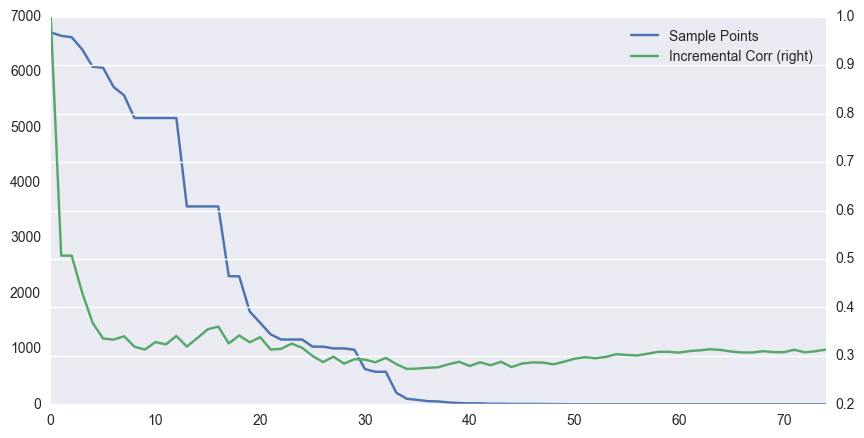

In [507]:
#display(pd.Series(1, finalData.index, name='Avg. Pairwise Corr'))
tempCorr = finalData.corr()

tempdata = finalData.notnull().sum()
tempdata = tempdata.divide(tempdata.max())
tempdata = tempdata.multiply(tempCorr.mean(axis=0).abs().subtract(1).abs()).sort_values(ascending=False)

tempLabels = []
incrementalCorr = []
while(len(tempLabels) < 75):
    tempLabels.append(tempdata.index.values[0])
    incrementalCorr.append(tempCorr.ix[tempLabels, tempLabels].abs().mean().mean())
    #display(tempLabels)
    tempdata = finalData.notnull().sum().ix[list(set(tempCorr.columns.values) - set(tempLabels))]
    tempdata = tempdata.divide(tempdata.max())
    tempdata = tempdata.multiply(tempCorr.ix[tempLabels, list(set(tempCorr.columns.values) - set(tempLabels))].mean(axis=0).abs().subtract(1).abs()).sort_values(ascending=False)

featurePoints = pd.Series(finalData.notnull().loc[:, tempLabels].cumprod(axis=1).sum().values, range(len(tempLabels)), name='Sample Points')
incrementalCorr = pd.Series(incrementalCorr, range(len(tempLabels)), name='Incremental Corr')

display(pd.concat([featurePoints, incrementalCorr], axis=1).head(40))

fig = plt.figure(figsize=(10, 5))
featurePoints.plot(legend=True)
incrementalCorr.plot(secondary_y=True, legend=True)

finalFeatures = finalData.notnull().loc[:, tempLabels].cumprod(axis=1).sum()

In [508]:
cutoff = 5000
finalFeatures = (finalFeatures[finalFeatures.gt(cutoff)]).index.values

In [509]:
#tempdata = logCompanyData.median(level=1)
#tempdata = tempdata.notnull().sum().divide(np.shape(tempdata)[0])
#Keep those features that are reported by atleast 2/3 of the companies
#finalData = finalData.iloc[:, :15].dropna(how='any')
#finalFeatures = finalData.columns
#finalData = finalData.loc[:, finalFeatures].dropna(how='any')
display(pd.DataFrame(finalFeatures, columns=['Final Features']))
#display(finalData.corr())

,Final Features
0,CommonStockSharesAuthorized
1,StockholdersEquity
2,Liabilities
3,ComprehensiveIncomeNetOfTax
4,CommonStockValue
5,CommonStockSharesOutstanding
6,CommonStockParOrStatedValuePerShare
7,CashAndCashEquivalentsAtCarryingValue
8,RetainedEarningsAccumulatedDeficit
9,CommonStockSharesIssued


Now we plot the distributions of each feature, ignoring any missing values.

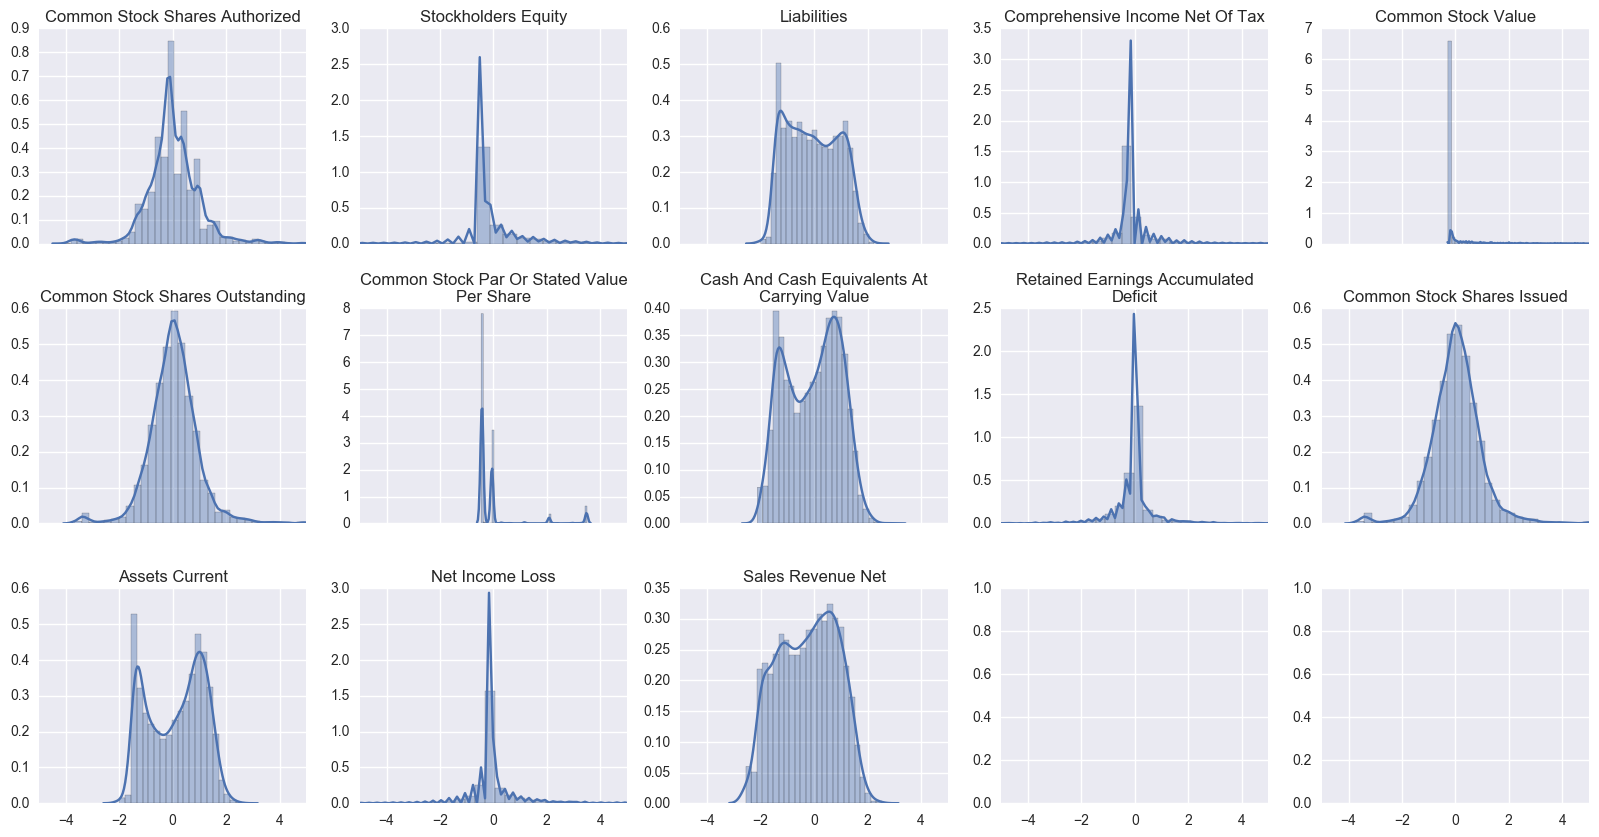

In [510]:
#Plot the distributions of each features.
fig, axes = plt.subplots(1+len(finalFeatures)/5, 5, figsize=(20,10), sharex=True)
axes[0][0].set_xlim([-5, 5])
fig.subplots_adjust(hspace=.3)
tempdata = finalData.loc[:, finalFeatures].dropna(how='any')
tempLabels = list(range(len(finalFeatures)))
while(len(tempLabels)>0):
    sns.distplot(tempdata.loc[:, finalFeatures[tempLabels[0]]], ax=axes[tempLabels[0]/5, np.mod(tempLabels[0], 5)], axlabel=False)
    axes[tempLabels[0]/5, np.mod(tempLabels[0], 5)].set(title=formatIndicatorString(finalFeatures[tempLabels.pop(0)], wrapword=True, wrap_length=35))

At first glance, some of the features look like bi-modal distributions.  However, some of the features appear to suffer from outliers and we must explore a little further.  This part must be performed very cautiously as we do not want to remove extremely low values that may be indicate companies close to bankruptcy as they can provide valuable information for our analysis.  Next, we attempt to group the features in to subclasses that result in the pairwise correlations above a certain threshold.  This is done to fill in missing values for the features since there is actually no company that reports every single feature.  For features that do not fall under any group, we shall fill in the average value for all other features.

## Dimensionality Reduction

In [511]:
from sklearn.decomposition import PCA, RandomizedPCA

tempdata = finalData.loc[:, finalFeatures].dropna(how='any')
pca = PCA(n_components=min(15, len(finalFeatures)))
pca.fit(tempdata)
pca_results = pd.DataFrame(pca.transform(tempdata), columns=['PC_' + str(x) for x in range(pca.n_components_)])
display(pd.DataFrame(pca.explained_variance_ratio_.cumsum(), columns=['Cum. Explained Variance']))



,Cum. Explained Variance
0,0.410887
1,0.617416
2,0.778145
3,0.849130
4,0.894995
5,0.926957
6,0.953230
7,0.971497
8,0.986556
9,0.991735


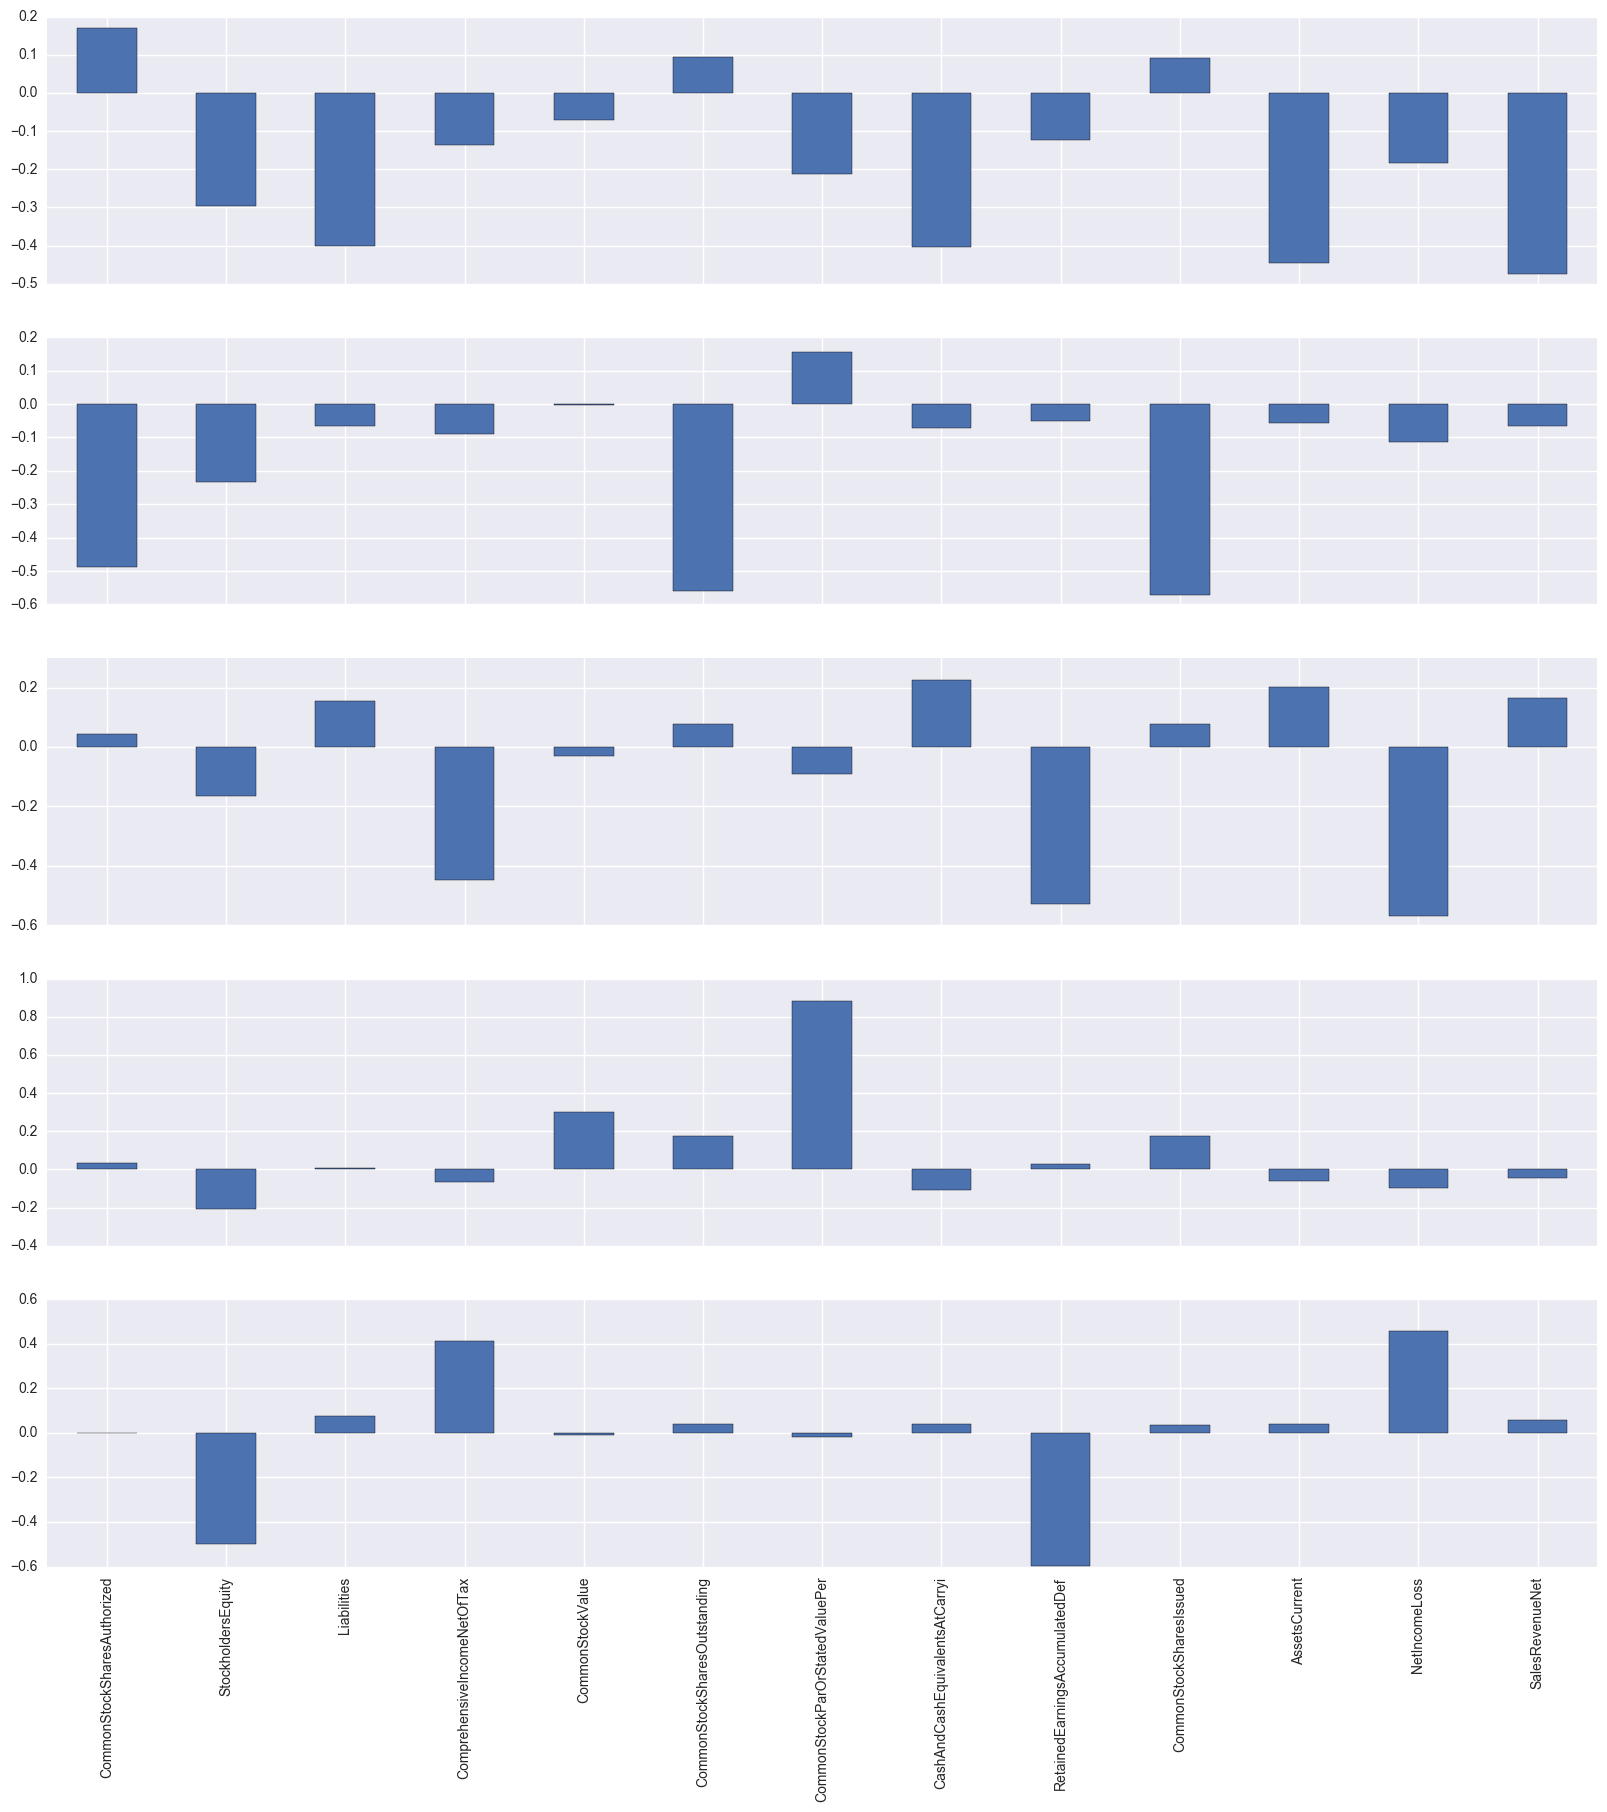

In [512]:
tempdata = finalData.loc[:, finalFeatures].dropna(how='any')
pca = PCA(n_components=5)
pca.fit(tempdata)
pca_results = pd.DataFrame(pca.transform(tempdata), columns=['PC_' + str(x) for x in range(pca.n_components_)])

pca_components = pd.DataFrame(pca.components_, columns=[x[:30] for x in tempdata.columns.values])
fig, axes = plt.subplots(pca.n_components_, 1, figsize=(20,20), sharex=True)
for c in range(pca.n_components_):
    pca_components.iloc[c, :].plot(kind='bar', ax=axes[c])


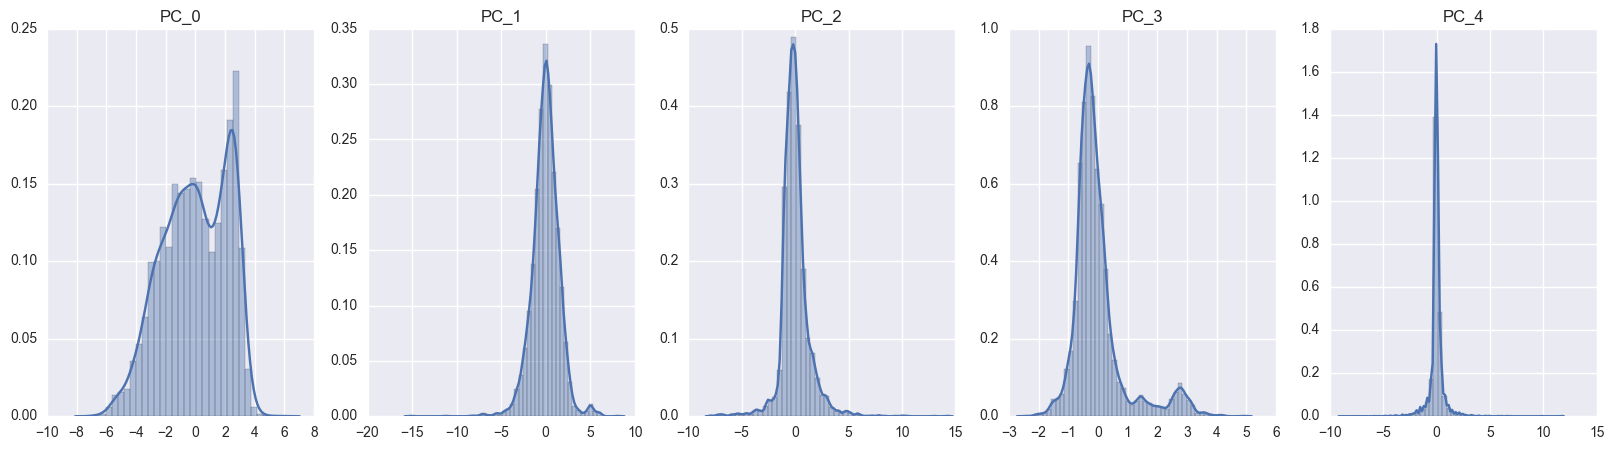

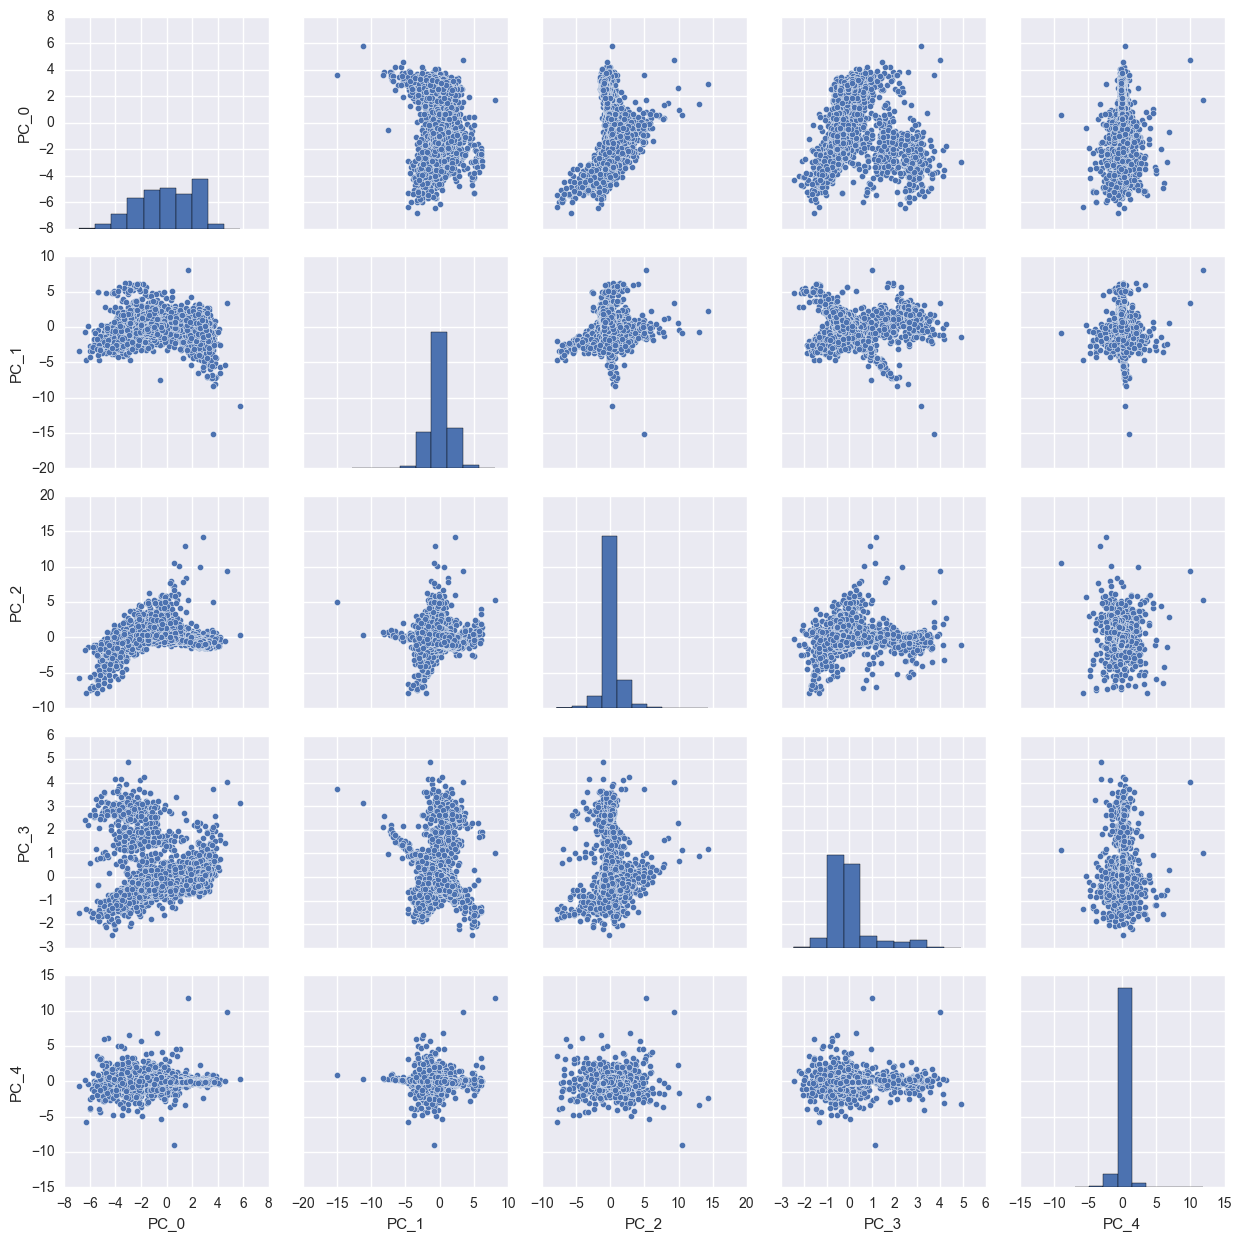

In [513]:
#Plotting Distributions and Pair Plots
fig, axes = plt.subplots(1, pca.n_components_, figsize=(20,5), sharex=False)
fig.subplots_adjust(hspace=.5)
for c in range(pca.n_components_):
    sns.distplot(pca_results.iloc[:, c], ax=axes[c], axlabel=False)
    axes[c].set(title=pca_results.columns.values[c])

#fig = plt.figure(figsize=(20, 10))

sns.pairplot(pca_results)

Attempt to separate the underlying drivers behind the components.

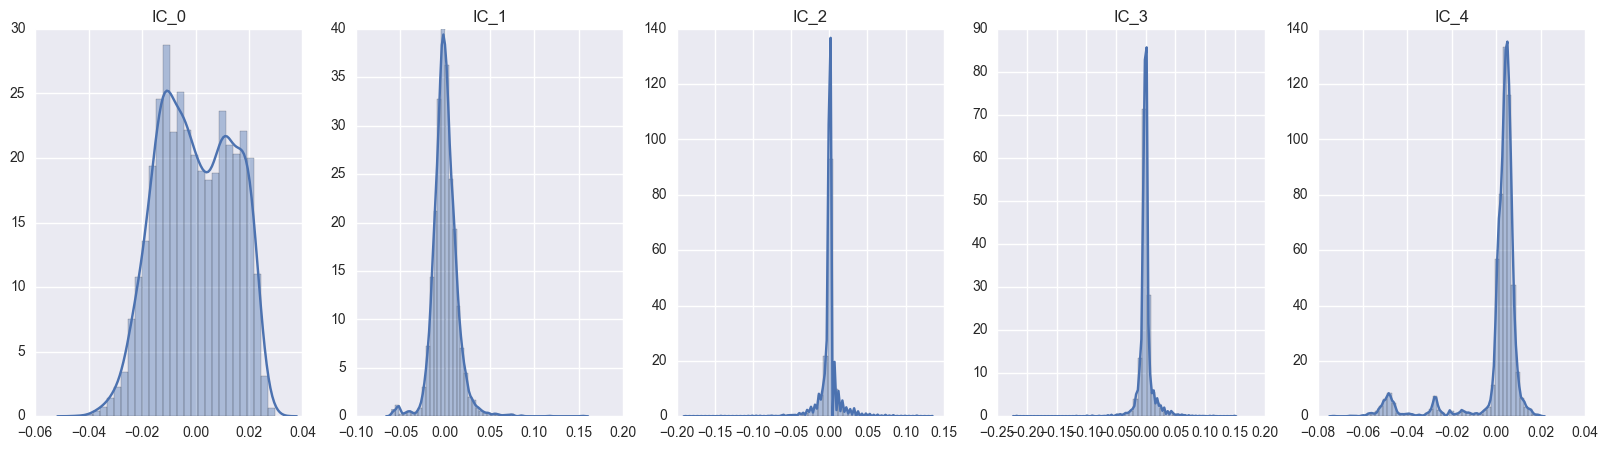

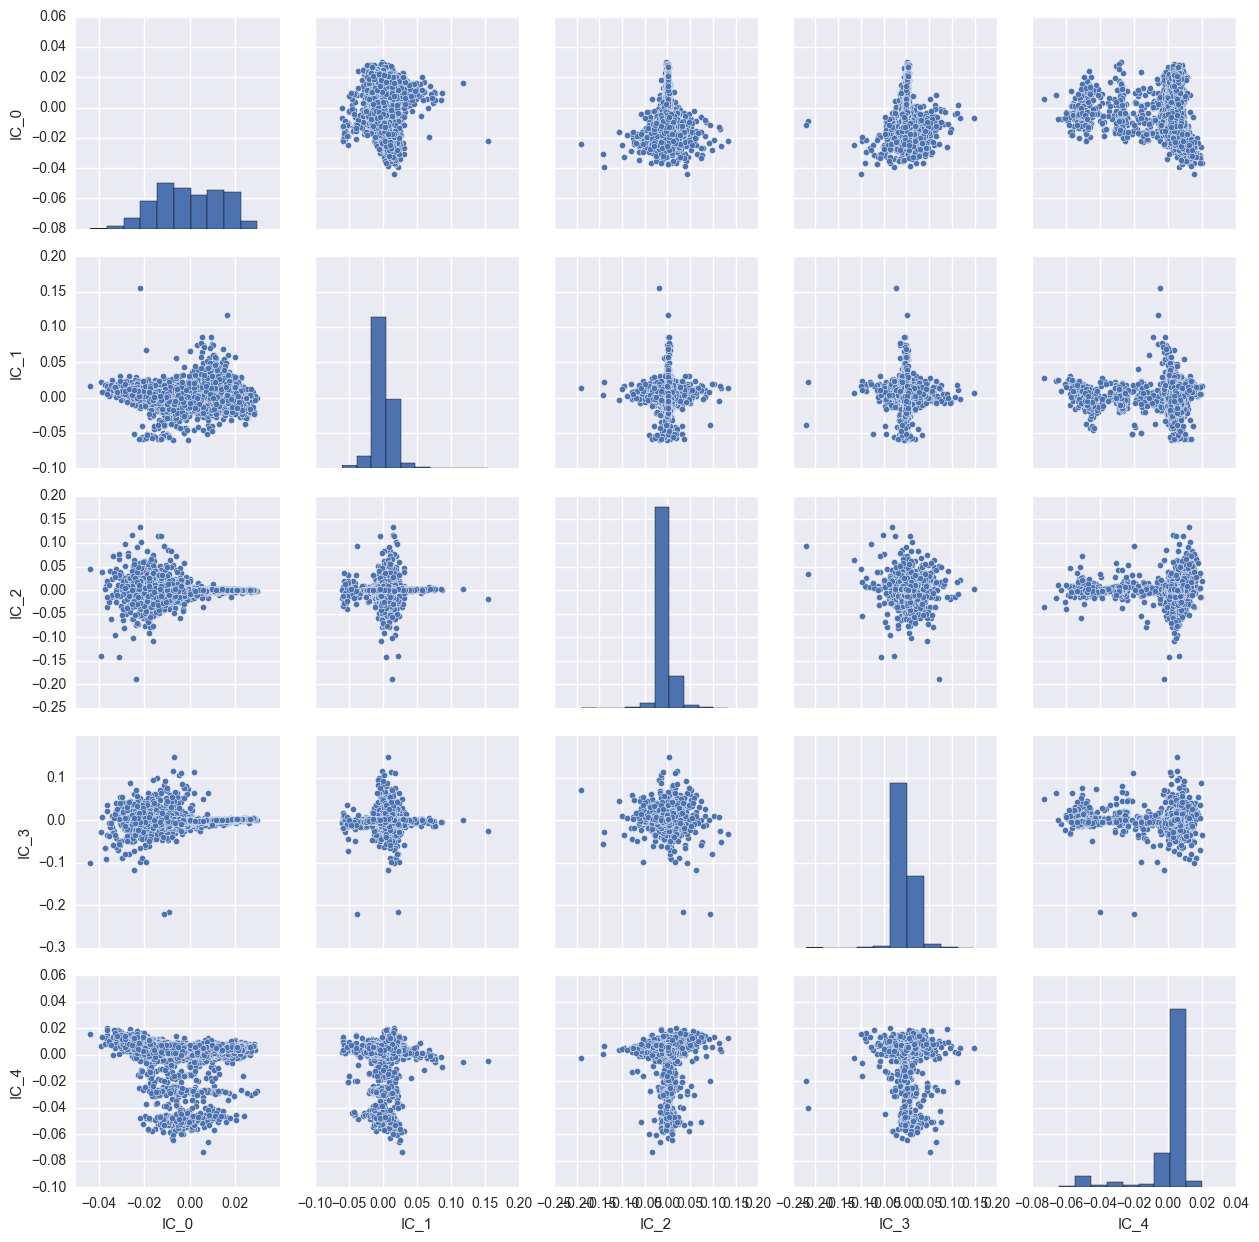

In [514]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=pca.n_components_)
tempdata = pca_results
ica.fit(tempdata)

ica_results = pd.DataFrame(ica.transform(tempdata), columns=['IC_' + str(x) for x in range(ica.n_components)])
ica_results.index = tempdata.index

fig, axes = plt.subplots(1, ica.n_components, figsize=(20,5), sharex=False)
fig.subplots_adjust(hspace=.5)
for c in range(ica.n_components):
    sns.distplot(ica_results.iloc[:, c], ax=axes[c], axlabel=False)
    axes[c].set(title=ica_results.columns.values[c])
sns.pairplot(ica_results)

In [515]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import cluster, covariance
from sklearn.mixture import GMM, DPGMM# BayesianGaussianMixture

In [516]:
display(pca_results.tail())
display(ica_results.tail())

,PC_0,PC_1,PC_2,PC_3,PC_4
5166,3.110638,-0.366054,-0.902057,0.119748,-0.151108
5167,2.807721,0.966721,-1.085800,-0.098723,-0.202374
5168,2.975816,0.172056,-0.967932,0.102392,-0.153035
5169,1.871886,0.690281,-0.718678,-0.133210,0.005280
5170,2.475079,1.815639,-1.122152,-0.397625,-0.226876


,IC_0,IC_1,IC_2,IC_3,IC_4
5166,0.020598,0.006809,0.000792,0.002825,0.004853
5167,0.021878,-0.005901,0.000730,0.002831,0.004035
5168,0.021208,0.002066,0.000818,0.002407,0.003528
5169,0.014218,-0.004485,0.002247,-0.000152,0.003553
5170,0.021072,-0.014940,0.000694,0.002759,0.005516


In [569]:
numClusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40]
#numClusters = [25, 30, 35, 45, 50, 55, 60]#, 8, 9, 10, 15, 20, 25]
bicValues = []
silhouetteValues = [np.nan]
tempdata = pca_results
for eachCluster in numClusters:
    #clusterer = GMM(n_components=eachCluster, min_covar=0.00001, random_state=0, covariance_type='spherical')
    #clusterer = cluster.DBSCAN(eps=eachCluster/10.0, min_samples=10)
    #clusterer = cluster.SpectralClustering(n_clusters=eachCluster)
    clusterer = cluster.KMeans(n_clusters=eachCluster, random_state=0)
    #clusterer = DPGMM(n_components=eachCluster, min_covar=0.00001, random_state=0,  covariance_type='tied')
    clusterer.fit(tempdata.values)
    if hasattr(clusterer, 'bic'):
        bicValues.append(clusterer.bic(tempdata.values))
    elif hasattr(clusterer, 'score'):
        bicValues.append(clusterer.score(tempdata.values))
    else:
        bicValues.append(0)
    if hasattr(clusterer, 'labels_'):
        clustPreds = (clusterer.labels_.astype(np.int))
    else:
        clustPreds = (clusterer.predict(tempdata.values))
    if eachCluster > 1:
        try:
            silhouetteValues.append(silhouette_score(tempdata.values, clustPreds, sample_size=1000, random_state=0))
        except:
            silhouetteValues.append(0)
    #print('Score for n=' + str(eachCluster) + ' is ' + str(silhouetteValues[-1]))

1    -53330.421346
2    -35446.593954
3    -28319.745067
4    -24146.202430
5    -20923.394476
6    -18515.902391
7    -16701.066885
8    -15213.543409
9    -14093.026250
10   -13248.992381
11   -10172.419986
12    -8387.087190
13    -7188.492756
14    -6386.456385
15    -5771.118139
16    -5313.763891
Name: BIC, dtype: float64

1          NaN
2     0.322975
3     0.322684
4     0.346624
5     0.303305
6     0.302428
7     0.295362
8     0.307357
9     0.297954
10    0.280720
11    0.277024
12    0.265267
13    0.263435
14    0.268635
15    0.260504
16    0.258949
Name: Silhouette Scores, dtype: float64

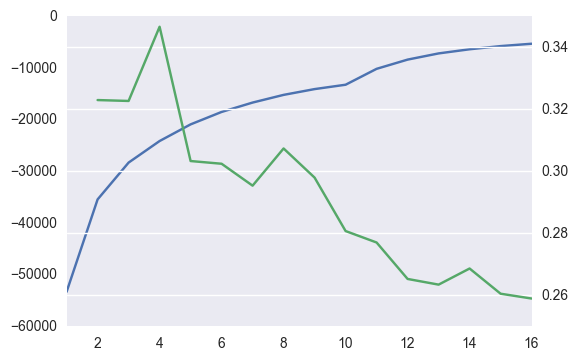

In [570]:

bicValues = pd.Series(bicValues, np.arange(1, len(bicValues)+1), name='BIC')
silhouetteValues = pd.Series(silhouetteValues, np.arange(1, len(silhouetteValues)+1), name='Silhouette Scores')
bicValues.plot()
silhouetteValues.plot(secondary_y=True)
display(bicValues)
display(silhouetteValues)

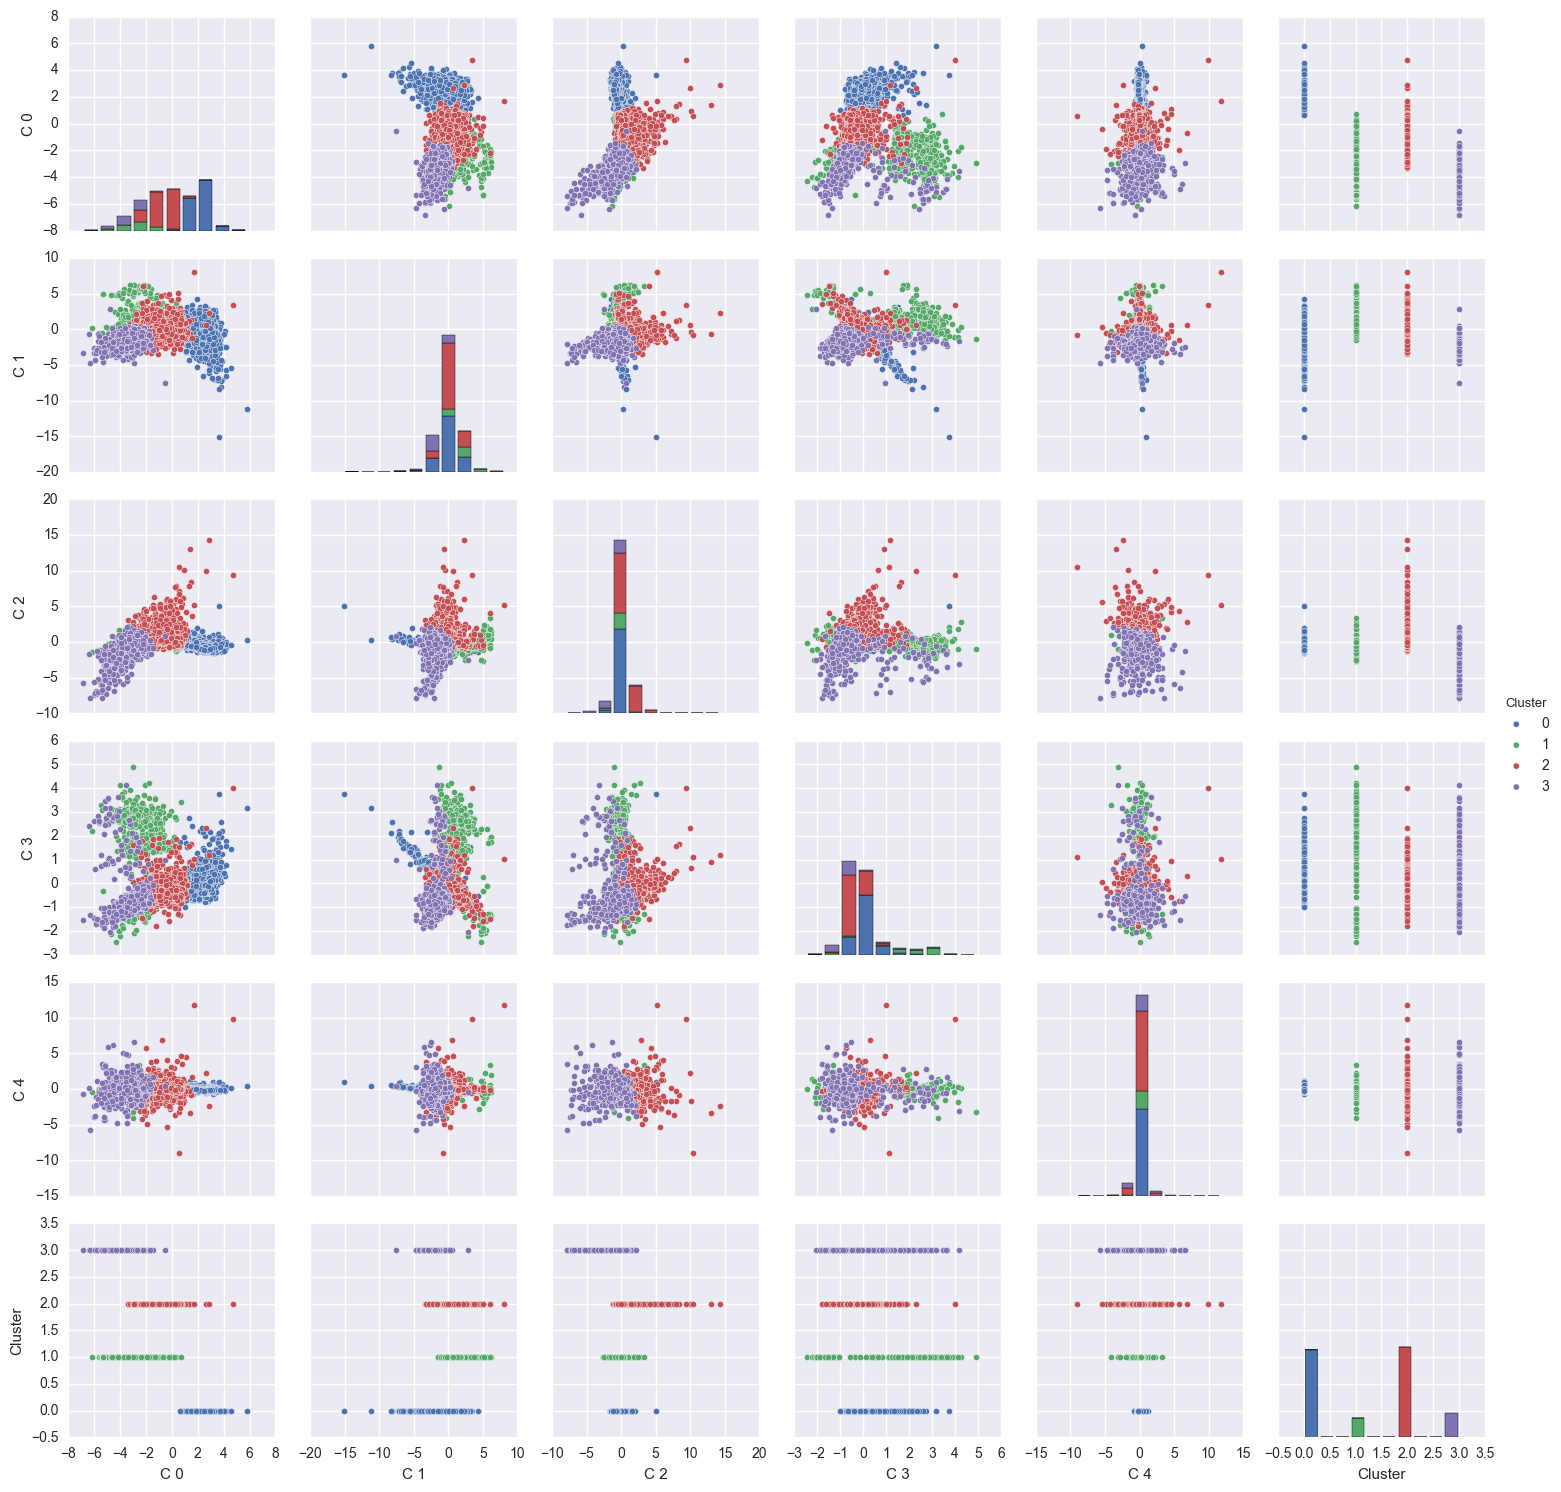

In [571]:
#Set the final clustering model and corresponding parameters
clusterer = cluster.KMeans(n_clusters=4, random_state=0)
#clusterer = cluster.SpectralClustering(n_clusters=3)
#clusterer = cluster.DBSCAN(eps=0.7, min_samples=10)
#clusterer = GMM(n_components=7, min_covar=0.00001, random_state=0, covariance_type='spherical')
#clusterer = DPGMM(n_components=10, random_state=0, min_covar=0.00001, covariance_type='tied')
#display(ica_results)
clusterer.fit(tempdata.values)
if hasattr(clusterer, 'labels_'):
    clustPreds = clusterer.labels_.astype(np.int)
else:
    clustPreds = clusterer.predict(tempdata.values)

finalClusters = pd.concat([pd.DataFrame(tempdata.values, columns=['C ' + str(x) for x in range(np.shape(tempdata.values)[1])]), pd.Series(clustPreds, name='Cluster')], axis=1)
finalClusters.index = tempdata.index
sns.pairplot(finalClusters, hue='Cluster')
clustPreds = pd.Series(clustPreds, finalData.loc[:, finalFeatures].dropna(how='any').index, name='Cluster')


## Exploring the Clusters and types of companies in them

We start with finding the cluster centres and converting them back to the original data format.  This involves first transforming the independent components to their corresponding principal component counter parts.  Then, applying the reverse transformation to retrieve our log data for all the features and then finally to get the original dollar value by reversing the log transformation method we had used earlier.

In [566]:
from scipy import stats

#clusterCentres = pd.DataFrame(clusterer.means_, columns=['IC_' + str(x) for x in range(np.shape(clusterer.means_)[1])])
clusterCentres = pd.DataFrame(clusterer.cluster_centers_, columns=['IC_' + str(x) for x in range(np.shape(clusterer.cluster_centers_)[1])])
display(clusterCentres)

#tempdata = pca.inverse_transform(clusterCentres.values)

tempdata = ica.inverse_transform(clusterCentres.values)
tempdata = pca.inverse_transform(tempdata)#clusterCentres.values)

#display(pd.DataFrame(tempdata, columns=finalFeatures))
tempdata = pd.DataFrame(tempdata, columns=finalFeatures)
#display(logCompanyDataStd)
#tempdata = tempdata.multiply(logCompanyDataStd)#.add(logCompanyDataMean)
#tempdata = np.exp(tempdata.multiply(logCompanyDataStd.loc[finalFeatures]).add(logCompanyDataMean.loc[finalFeatures])).add(logCompanyDataTransformation.loc[finalFeatures])
tempdata = inverseLogData(tempdata)
display(tempdata.divide(1000000))
#for c in range(len(tempdata.index)):

#centroidPct = (pd.DataFrame(np.reshape(map(lambda x, y: stats.percentileofscore(companyData.median(level=1).loc[:, y], tempdata.loc[x, y]), np.tile(np.arange(clusterer.n_components), len(finalFeatures)), np.repeat(finalFeatures, clusterer.n_components)), (len(finalFeatures), clusterer.n_components))).T)
centroidPct = (pd.DataFrame(np.reshape(map(lambda x, y: stats.percentileofscore(companyData.median(level=1).loc[:, y], tempdata.loc[x, y]), np.tile(np.arange(clusterer.n_clusters), len(finalFeatures)), np.repeat(finalFeatures, clusterer.n_clusters)), (len(finalFeatures), clusterer.n_clusters))).T)
centroidPct.columns = finalFeatures
#centroidPct = pd.DataFrame(stats.percentileofscore(companyData.median(level=1).iloc[:, 0], tempdata.iloc[1, 0]), columns=finalFeatures)
display(centroidPct.T)


,IC_0,IC_1,IC_2,IC_3,IC_4
0,0.015203,-0.005304,0.000355,0.000783,0.004295
1,-0.007539,-0.006115,-0.000554,-0.003138,0.003498
2,-0.017200,0.004614,-0.033244,0.005063,0.005325
3,0.010706,0.019086,0.000226,-0.001340,0.002520
4,-0.021011,0.009154,0.019939,-0.035498,0.004119
5,-0.017892,0.002955,0.017917,0.025281,0.006007
6,-0.001794,-0.000741,0.000081,0.000881,-0.042382


,CommonStockSharesAuthorized,StockholdersEquity,Liabilities,ComprehensiveIncomeNetOfTax,CommonStockValue,CommonStockSharesOutstanding,CommonStockParOrStatedValuePerShare,CashAndCashEquivalentsAtCarryingValue,RetainedEarningsAccumulatedDeficit,CommonStockSharesIssued,AssetsCurrent,NetIncomeLoss,SalesRevenueNet
0,113.607603,-29.126695,1.181202,-0.681462,-0.336500,16.211467,1.201346e-09,0.045011,14.440275,16.224126,0.317844,-0.387564,0.028037
1,72.968669,147.028487,63.826752,-0.427708,0.542778,15.895972,7.168427e-09,14.842851,-83.677454,16.313426,59.254424,0.063375,35.358645
2,196.374987,285.126655,174.028853,-19.922155,0.677475,54.149836,3.220056e-09,62.068253,-186.252092,55.771788,237.695562,-17.891232,97.608093
3,672.078629,22.477956,2.172047,-0.859143,1.055476,156.519837,2.368075e-09,0.099797,-57.058501,158.376437,0.524585,-0.729846,0.072585
4,195.298318,-33.545484,396.023460,7.042410,1.054400,67.192230,6.100264e-09,74.667214,-557.165731,69.268865,347.349867,6.187042,174.599237
5,166.179704,718.193848,589.569821,16.771736,1.895339,50.406178,8.428147e-09,91.462804,382.984084,53.624643,579.501167,17.678818,334.797802
6,24.204628,139.518561,239.227437,3.531211,13.172887,11.904534,1.928766e-07,19.225068,134.216693,12.225403,145.119281,3.924949,106.560217


,0,1,2,3,4,5,6
CommonStockSharesAuthorized,42.976382,22.773404,50.308261,76.268614,50.308261,48.857062,9.940245
StockholdersEquity,2.750640,59.546619,66.707768,42.862563,2.617851,75.547757,58.958551
Liabilities,16.399507,43.308356,49.388220,20.117614,55.325809,58.674002,51.541307
ComprehensiveIncomeNetOfTax,15.574315,16.911695,2.883430,14.739638,36.811154,42.103766,33.074078
CommonStockValue,0.018970,59.669923,61.472067,65.332448,65.322963,68.415062,75.519302
CommonStockSharesOutstanding,25.685289,25.315375,52.764868,69.980082,56.966708,51.038604,20.553922
CommonStockParOrStatedValuePerShare,46.703974,47.462772,47.054918,46.865219,47.434317,47.500711,75.291663
CashAndCashEquivalentsAtCarryingValue,17.679977,48.250024,65.986911,20.639287,68.614246,71.089823,51.247273
RetainedEarningsAccumulatedDeficit,60.267476,17.689462,10.974106,20.866926,4.410509,76.183250,70.710424
CommonStockSharesIssued,26.529451,26.633785,55.249929,73.442094,59.850138,54.310917,22.071517


In [567]:
display(pd.DataFrame(centroidPct.max().subtract(centroidPct.min()).sort_values(ascending=False)))


,0
CommonStockValue,75.500332
NetIncomeLoss,75.481362
StockholdersEquity,72.929906
RetainedEarningsAccumulatedDeficit,71.772740
CommonStockSharesAuthorized,66.328370
CashAndCashEquivalentsAtCarryingValue,53.409845
CommonStockSharesIssued,51.370578
CommonStockSharesOutstanding,49.426160
AssetsCurrent,46.049512
Liabilities,42.274495


## How do the different clusters perform in the market?

Lets get a sample of 25 companies that are randomly selected from each cluster.

In [568]:
#tempdata = finalData.loc[:, finalFeatures].dropna(how='any')
#display(pd.Series(clusterer.predict(pca.transform(tempdata.values))).eq(1).sum())

display(finalClusters.loc[:, 'Cluster'].value_counts().sort_index())
sample = {}
for c in np.sort(clustPreds.unique()):
    sample[c] = (np.random.choice(clustPreds[clustPreds.eq(c)].index, 25))
#sample_1 = (np.random.choice(clustPreds[clustPreds.eq(1)].index, 25))
#sample_2 = (np.random.choice(clustPreds[clustPreds.eq(2)].index, 25))
#sample_3 = (np.random.choice(clustPreds[clustPreds.eq(3)].index, 25))
#sample_4 = (np.random.choice(clustPreds[clustPreds.eq(4)].index, 25))
#sample_5 = (np.random.choice(clustPreds[clustPreds.eq(5)].index, 25))


#display(finalClusters.loc[:, 'Cluster'].value_counts().sort_index())
#display(finalClusters)
#display(finalData.loc[:, finalFeatures].dropna(how='any'))
#display(finalClusters.loc[:, 'Cluster']())
#display(finalClusters.loc[:, 'Cluster'].eq(1).sum())

0    1350
1    1817
2     277
3     780
4     149
5     364
6     434
Name: Cluster, dtype: int64

The fundamentals database, unfortunately, does not contain historical prices and also does not have trading tickers that we can use to find historical prices from other sources.  As a result, we need to define some functions that we can use to query the SEC public filings to complete the database.

In [291]:
import xml.etree.ElementTree
import urllib2


def getIssuerInfoFromEdgar(inputTickerCIK):
    #This function uses the latest Form 4 filing on Edgar for a specific ticker or CIK to retrieve issuer info.
    try:
        #Search for the company's top 10 Form 4 filings
        tempfile = urllib2.urlopen('https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + str(inputTickerCIK) + '&count=10&type=4&owner=only&output=xml').read()
        #Locate the most recent one
        data = xml.etree.ElementTree.fromstring(tempfile)
        #Open the complete text submission using the file number
        tempfile = urllib2.urlopen(data[1][0][1].text[:data[1][0][1].text.find('-index.htm')] + '.txt').read()
        #Populate a dictionary with all the necessary information.
        if tempfile.find('<issuer>')==-1 | tempfile.find('</issuer>')==-1:
            return None
        else:
            results = {}
            results['ISSUER_CIK'] = (tempfile[tempfile.find('<issuerCik>')+11:tempfile.find('</issuerCik>')])
            results['ISSUER_NAME'] = (tempfile[tempfile.find('<issuerName>')+12:tempfile.find('</issuerName>')])
            results['ISSUER_TICKER'] = (tempfile[tempfile.find('<issuerTradingSymbol>')+21:tempfile.find('</issuerTradingSymbol>')])
            return results
    except:
        return None

def getIssuerInfoForList(inputTickerList):
    #Use this function to get informaiton on a list of tickers.  Returns an array of dictionarys
    results = []
    for eachTicker in inputTickerList:
        results.append(getIssuerInfoFromEdgar(eachTicker))
    return results
    
def getCIKFromTicker(inputTicker):
    #We use the following funciton to retrieve the CIK number for a specific ticker by querying EDGAR.
    #The CIK number is used to link the historical prices with the XBRL database hosted at usfundamentals.com.
    try:
        file = urllib2.urlopen('https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=' + str(inputTicker) + '&count=10&output=xml').read()
        data = xml.etree.ElementTree.fromstring(file)
        return data[0][0].text
    except:
        return None

#Use the following for getting multiple tickers
def getCIKFromTickerList(inputTickers):
    outputCIK = []
    for eachTicker in inputTickers:
        outputCIK.append(getCIKFromTicker(eachTicker))
    return outputCIK

#Test the connection, by querying for Micosoft (MSFT), we should get 0000789019:
print('CIK for MSFT is ' + str(getCIKFromTicker('MSFT')) + '.')

#Test group with an incorrect ticker:
test_tickers = ['AAPL', 'NON_EXISTENT_TICKER', 'XOM', '0000789019', 'GOOG', '0001412270']
test_cik = getIssuerInfoForList(test_tickers)
for c in range(len(test_tickers)):
    print('INFO for ' + test_tickers[c] + ' is ' + str(test_cik[c]) + '.')


CIK for MSFT is 0000789019.
INFO for AAPL is {'ISSUER_TICKER': 'AAPL', 'ISSUER_CIK': '0000320193', 'ISSUER_NAME': 'APPLE INC'}.
INFO for NON_EXISTENT_TICKER is None.
INFO for XOM is {'ISSUER_TICKER': 'XOM', 'ISSUER_CIK': '0000034088', 'ISSUER_NAME': 'EXXON MOBIL CORP'}.
INFO for 0000789019 is {'ISSUER_TICKER': 'MSFT', 'ISSUER_CIK': '0000789019', 'ISSUER_NAME': 'MICROSOFT CORP'}.
INFO for GOOG is {'ISSUER_TICKER': 'GOOG', 'ISSUER_CIK': '0001652044', 'ISSUER_NAME': 'Alphabet Inc.'}.
INFO for 0001412270 is {'ISSUER_TICKER': 'CRCM', 'ISSUER_CIK': '0001412270', 'ISSUER_NAME': 'Care.com Inc'}.


In [63]:
getIssuerInfoFromEdgar('0001062506')

{'ISSUER_CIK': '0001062506',
 'ISSUER_NAME': 'ATLANTICA INC',
 'ISSUER_TICKER': 'ATTC.OB'}

In [331]:
for 
sample_0_info = getIssuerInfoForList(sample_0)
sample_1_info = getIssuerInfoForList(sample_1)
sample_2_info = getIssuerInfoForList(sample_2)
sample_3_info = getIssuerInfoForList(sample_3)
sample_4_info = getIssuerInfoForList(sample_4)
sample_5_info = getIssuerInfoForList(sample_5)

In [334]:
sample_5_info

[None,
 {'ISSUER_CIK': '0001357671',
  'ISSUER_NAME': 'Jerrick Media Holdings, Inc.',
  'ISSUER_TICKER': 'JMDA'},
 {'ISSUER_CIK': '0000919175',
  'ISSUER_NAME': 'Sugarmade, Inc.',
  'ISSUER_TICKER': 'SGMD'},
 {'ISSUER_CIK': '0001424879',
  'ISSUER_NAME': 'Moody National REIT I, Inc.',
  'ISSUER_TICKER': 'N/A'},
 {'ISSUER_CIK': '0001375793',
  'ISSUER_NAME': 'GTX CORP',
  'ISSUER_TICKER': 'GTXO'},
 {'ISSUER_CIK': '0001045929',
  'ISSUER_NAME': 'FIRST COLOMBIA GOLD CORP.',
  'ISSUER_TICKER': 'FCGD'},
 None,
 {'ISSUER_CIK': '0001288469',
  'ISSUER_NAME': 'MAXLINEAR INC',
  'ISSUER_TICKER': 'MXL'},
 {'ISSUER_CIK': '0001190370',
  'ISSUER_NAME': 'INNOVATIVE DESIGNS INC',
  'ISSUER_TICKER': 'IVDN'},
 {'ISSUER_CIK': '0001421907',
  'ISSUER_NAME': 'Trident Brands Inc',
  'ISSUER_TICKER': 'TDNT'},
 None,
 {'ISSUER_CIK': '0001002360',
  'ISSUER_NAME': 'ABSOLUTE POTENTIAL, INC.',
  'ISSUER_TICKER': 'ABLP'},
 None,
 {'ISSUER_CIK': '0001021096',
  'ISSUER_NAME': 'ROOMLINX INC',
  'ISSUER_TICKER': '

In [288]:
getIssuerInfoFromEdgar('931799')

{'ISSUER_CIK': '0000931799',
 'ISSUER_NAME': 'GlyEco, Inc.',
 'ISSUER_TICKER': 'GLYE'}

In [289]:
str('a')

'a'